## Environment setup

In [ ]:
# This code allows for multiple outputs to be shown in the same cell rather than the last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Loading necessary packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import sys
import pandas as pd
import matplotlib.dates as mdates
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

!pip install itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [ ]:
# figure formats
font = {'family':'DejaVu Sans',
        'size': 12}
plt.rc('font', **font)

# numpy number precision
np.set_printoptions(precision=4, suppress=True)

DATA_FILE_MVA = '/content/20-crypto-investing-mva.csv'
DATA_FILE_ETF = '/content/21-crypto-investing-etf.csv'

TOL = 1.0e-8                                    # Numerical tolerance for comparisons
SEED = 24                                       # Random number seed
MONTH_SCALE = 12
DAY_SCALE = 252

# Ingest raw data

## Inspect raw data

In [ ]:
!head -5 $DATA_FILE_MVA
!head -5 $DATA_FILE_ETF

date,stock,bond,btc,rf
2014-10-31,0.0252,0.00938558039380144,0.11742097403385054,0.0
2014-11-30,0.0255,0.006549415049906804,-0.1530338938256398,0.0
2014-12-31,-0.0006,-0.0017419664501973076,-0.3208345911554661,0.0
2015-01-31,-0.0311,0.025870096248430396,0.1692187863458139,0.0
date,bito,xbtf,btc
2021-11-17,0.012297173932569905,0.013058730955968656,0.003436857419424788
2021-11-18,-0.04083737505395135,-0.03784493597239913,-0.056749839897770826
2021-11-19,-0.0026947722259558216,-0.0024046547165123,0.02067785780169218
2021-11-22,-0.03566601111407797,-0.039256248648200764,-0.04156594059612895


In [ ]:
!tail -5 $DATA_FILE_MVA
!tail -5 $DATA_FILE_ETF

2022-02-28,-0.0229,-0.011272467785812923,0.05430112933051223,0.0
2022-03-31,0.0304,-0.029133293295735885,-0.1718056277838519,0.0001
2022-04-30,-0.0947,-0.037761173806980075,-0.157035240153918,0.0001
2022-05-31,-0.0037,0.005776431143414307,-0.37768830819165067,0.0003
2022-06-30,-0.0849,-0.01511669728249343,0.17954101663669286,0.0006
2022-08-01,-0.04180714767363447,-0.037849419354838765,-0.0009725914075834341
2022-08-02,-0.0014074595355384467,0.0008046043448992624,-0.014415336672859325
2022-08-03,0.023960535588442466,0.02063605502947996,-0.005727596126488987
2022-08-04,-0.04817618719889882,-0.0450765864332604,-0.009434736536729993
2022-08-05,0.024584237165582,0.02245641613198912,0.029091011091496366


In [ ]:
!wc $DATA_FILE_MVA #Word count. The number of words, lines, and bytes in the file
!wc $DATA_FILE_ETF

  94   94 6639 /content/20-crypto-investing-mva.csv
  181   181 13396 /content/21-crypto-investing-etf.csv


# Data dictionary

DataFile: 20-crypto-investing-mva.csv

| Position | Variable | Data Type | Description | Source
|:--------:|:---------|:---------|:---------|:---------|
| 0 | date | date | Calendar date - end of month | Ken French|
| 1 | stock | float | Value-weighted return to all NYSE, NASDAQ, and AMEX listed stocks | Ken French|
| 2 | bond | float | Vanguard Total Bond Market Index Fund| Yahoo! Finance |
| 3 | btc | float | Bitcoin USD (BTC-USD) | Yahoo! Finance |
| 4 | rf | float | Yield on 30-day treasury bill | Ken French |



DataFile: 21-crypto-investing-etf.csv

| Position | Variable | Data Type | Description | Source
|:--------:|:---------|:---------|:---------|:---------|
| 0 | date | date | Calendar date - end of month | Yahoo! Finance |
| 1 | bito | float | ProShares Bitcoin Strategy ETF | Yahoo! Finance |
| 2 | xbtf | float | VanEck Bitcoin Strategy ETF | Yahoo! Finance |
| 3 | btc | float | Bitcoin USD (BTC-USD) | Yahoo! Finance |

## Read data

- There seems to be a misalignment with the dates on the ETF csv. We are utilizing pandas dataframe to inspect it visually.
- It is important to note that since these two data sets cover vastly different spans of time, with the mva csv covering between 2014-10 to 2022-06 and the etf csv convering between 2021-11 and 2022-11. Understanding this, we aimed to analyze the different factors within their own data sets rather than across datasets.

In [ ]:
mva_df = pd.read_csv(DATA_FILE_MVA)
etf_df = pd.read_csv(DATA_FILE_ETF)

In [ ]:
np.min(mva_df["date"])
np.max(mva_df["date"])

np.min(etf_df["date"])
np.max(etf_df["date"])

'2014-10-31'

'2022-06-30'

'2021-11-17'

'2022-08-05'

In [ ]:
# read the date column into a 1-d array
dates_str_mva = np.genfromtxt(DATA_FILE_MVA,usecols=[0],skip_header=1,
                      delimiter=',',dtype=str)
dates_str_etf = np.genfromtxt(DATA_FILE_ETF,usecols=[0],skip_header=1,
                      delimiter=',',dtype=str)

# read remaining columns into a 2-d array
rets_labs_mva = ['stock','bond','btc','rf']
rets_labs_etf = ['bito','xbtf','btc']


rets_mva  = np.genfromtxt(DATA_FILE_MVA,usecols=np.arange(1,len(rets_labs_mva)+1),skip_header=1,
                      delimiter=',',dtype=float)
rets_etf  = np.genfromtxt(DATA_FILE_ETF,usecols=np.arange(1,len(rets_labs_etf)+1),skip_header=1,
                      delimiter=',',dtype=float)


# Create column labels for rets array
stock,bond,btc,rf = np.arange(len(rets_labs_mva))
bito,xbtf,btc = np.arange(len(rets_labs_etf))

In [ ]:
dates_str_mva

array(['2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
       '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
       '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
       '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
       '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
       '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
       '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
       '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
       '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
       '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
       '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
       '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
       '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
       '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
       '2019-10-31', '2019-11-30', '2019-12-31', '2020-

Convert string dates to Numpy datetime64

In [ ]:
dates_mva = np.empty_like(dates_str_mva, dtype='datetime64[M]')
for i, s in enumerate(dates_str_mva):
    l = s.split("-")
    d = f"{l[0]}-{l[1]}-01"
    dates_mva[i] = np.datetime64(d)


# We decided against modifying dates_stf into montly variables. Instead we changed it into datetime with days.
dates_etf = np.empty_like(dates_str_etf, dtype='datetime64[D]')
for i, s in enumerate(dates_str_etf):
     dates_etf[i] = np.datetime64(s)

## Test data read

Compare array rows and cols with raw data

In [ ]:
dates_mva.shape
dates_etf.shape

(93,)

(180,)

In [ ]:
# Assert function for the shape of mva dates and data
obs = 93
assert dates_mva.shape[0] == obs
assert rets_mva.shape[0] == obs
assert rets_mva.shape[1] == len(rets_labs_mva)

# Assert function for the shape of mva dates and data
obs = 180
assert dates_etf.shape[0] == obs
assert rets_etf.shape[0] == obs
assert rets_etf.shape[1] == len(rets_labs_etf)


Compare array values with raw data

In [ ]:
!head -2 $DATA_FILE_MVA
!tail -1 $DATA_FILE_MVA
!head -2 $DATA_FILE_ETF
!tail -1 $DATA_FILE_ETF

date,stock,bond,btc,rf
2014-10-31,0.0252,0.00938558039380144,0.11742097403385054,0.0
2022-06-30,-0.0849,-0.01511669728249343,0.17954101663669286,0.0006
date,bito,xbtf,btc
2021-11-17,0.012297173932569905,0.013058730955968656,0.003436857419424788
2022-08-05,0.024584237165582,0.02245641613198912,0.029091011091496366


In [ ]:
# Assert function to verify that the values in our arrays match the raw data
assert dates_mva[0] == np.datetime64("2014-10")
assert dates_mva[-1] == np.datetime64("2022-06")
assert np.isclose(rets_mva[0],[0.0252,0.00938558039380144,0.11742097403385054,0.0]).all()
assert np.isclose(rets_mva[-1],[-0.0849,-0.01511669728249343,0.17954101663669286,0.0006]).all()

assert dates_etf[0] == np.datetime64("2021-11-17")
assert dates_etf[-1] == np.datetime64("2022-08-05")
assert np.isclose(rets_etf[0],[0.012297173932569905,0.013058730955968656,0.003436857419424788]).all()
assert np.isclose(rets_etf[-1],[0.024584237165582,0.02245641613198912,0.029091011091496366]).all()

## Inspect data

Missing values?

In [ ]:
# No missing values in either data set
assert np.isnan(dates_mva).sum() == 0
assert np.isnan(dates_etf).sum() == 0
assert np.isnan(rets_mva).sum() == 0
assert np.isnan(rets_etf).sum() == 0

Are data sorted by date?

In [ ]:
assert (dates_mva[1:] - dates_mva[:-1] == np.timedelta64(1)).all()
assert np.all(np.diff(dates_etf) > np.timedelta64(0)) # Since the dates in dates_etf are mostly inconsistent in pattern,
                                                      # this assertion checks to see if the following date is always larger than the previous one

#Question 1:
 What questions should Bill answer to advise his clients on cryptocurrency as a potential investment? Think about the first step in the scientific method and the types of question his clients (any investors) might ask.

**Answer:** When building a cryptocurrency portfolio, Bill's clients will want to understand the value proposition of blockchain technology, the use cases of cryptocurrency transactions, current/future alternatives to blockchain, the legal landscape on crypto, as well as any innovations/advancements in the crypto space that may support/counter the crypto investment thesis.

**Understanding the Crypto Landscape:**

Objective: Clarify the fundamental aspects of cryptocurrency and blockchain technology.

Analysis Steps:
Investigate the value proposition of blockchain technology and its potential impact on various industries.
Assess the current and future use cases of cryptocurrency transactions.
Explore alternatives to blockchain technology that may emerge in the near or distant future.

**Risk Assessment and Investment Comfort:**

Objective: Determine the client's comfort level with cryptocurrency investment and sensitivity to price fluctuations.

Analysis Steps:
Evaluate the client's risk appetite and establish how comfortable they are with the inherent volatility of the crypto market.
Address concerns related to price fluctuations and potential losses.

**Portfolio Allocation and Investment Goals:**

Objective: Define the optimal size of the crypto portfolio in comparison to alternative investments and the total investment portfolio.

Analysis Steps:
Develop a strategic approach to portfolio allocation, considering the client's overall investment strategy.
Identify specific investment goals such as long-term wealth preservation, short-term gains, or portfolio diversification.

**Knowledge and Understanding of the Crypto Space:**

Objective: Assess Bill's comprehension of the crypto landscape, including centralized and decentralized exchanges.

Analysis Steps:
Evaluate Bill's understanding of the safety and security measures within the crypto/blockchain space.
Analyze the mechanisms of crypto trading, including centralized and decentralized exchanges.
Provide recommendations on cryptocurrencies that align with the client's investment objectives.

**Market Analysis and Global Macro Trends:**

Objective: Assess the current state of the cryptocurrency market and its relation to global macroeconomic trends and alternative markets.

Analysis Steps:
Conduct a thorough analysis of the cryptocurrency market, evaluating trends, and identifying potential indicators of market direction.
Examine the correlation between crypto trends and broader global economic factors.
Examine how cryptocurrency performs in comparison to alternative markets and if its inherent risk is worth the potential return.

**Regulatory Environment and Legal Implications:**

Objective: Understand the regulatory landscape surrounding cryptocurrency and anticipate potential impacts on the value and legality of the crypto portfolio.

Analysis Steps:
Stay informed about current regulatory frameworks governing cryptocurrencies.
Evaluate the potential impact of changes in regulations on the legal and financial aspects of the crypto portfolio.

**Exit Strategy and Portfolio Management:**

Objective: Define an exit strategy and conditions for portfolio liquidation or rebalancing.

Analysis Steps:
Develop clear criteria for when to liquidate or rebalance the crypto portfolio.
Establish guidelines for monitoring market conditions and making informed decisions regarding the portfolio.

#Question 2:
What types of analyses should Bill perform to answer the questions posed in 1.? (Think about the steps two and three in the scientific method.)

**Answer:**

To comprehensively address the questions posed in Question 1 and adhere to the scientific method, Bill should conduct a thorough analysis some of the analysis methods below.

**Market Comparison and Benchmarking:**

Objective: Understand how crypto compares to the stock or bond market and establish benchmarks for performance.

Analysis Steps: Conduct a comparative analysis of historical returns for crypto, stocks, and bonds.
Evaluate indicators such as annualized returns, volatility, and drawdowns.
Identify relevant market indices or benchmarks to compare against the crypto portfolio.

**Risk Measurement and Portfolio Structure:**

Objective: Measure risk and determine the optimal structure for the crypto portfolio relative to the overall portfolio.

Analysis Steps:
Calculate the Beta of bito, xbtf, and btc with respect to the market to assess their systematic risk.
Consider different risk tolerance levels and propose diversified portfolio structures based on these levels.
Determine the proportions of crypto ETFs and BTC to allocate within the crypto portfolio.

**Volatility Comparison:**

Objective: Evaluate the volatility of bito and xbtf relative to BTC by analyzing historical standard deviations and variances of returns.

Analysis Steps:
Calculate the standard deviations and variances of returns for bito, xbtf, and BTC.
Visualize the volatility comparison using charts or graphs.
Provide insights into how volatility levels may impact investment decisions.

**Performance Relative to ETFs:**

Objective: Assess the performance of BTC relative to ETFs like bito and xbtf using a time-series plot.

Analysis Steps:
Gather historical price data for BTC, bito, and xbtf.
Create a time-series plot to visually compare the performance trends.

**Sensitivity Analysis:**

Objective: Conduct sensitivity analysis to understand how changes in variables (e.g., risk levels, allocation proportions) affect the overall portfolio.

Analysis Steps:
Adjust risk tolerance levels and observe the impact on portfolio structure.
Evaluate the sensitivity of portfolio performance to changes in crypto ETF and BTC allocations.

**Statistical Analysis and Correlation:**

Objective: Explore statistical relationships and correlations between different crypto assets and traditional market instruments.

Analysis Steps:
Calculate correlation coefficients between crypto assets and traditional stock market indices.
Conduct regression analysis to identify factors influencing crypto performance.

**Question 3:** Perform a complete data science workflow aimed at providing compelling evidence on the investment theses behind cryptocurrencies.

# EDA

## Summary statistics

Statistical Properties Comparing Bitcoin to ETFs Summary (Annualized)

| Type | BTC | XBTF | BITO | Comments |
|:--------:|:---------|:---------| :---------|:---------|
| Mean: | -1.17487 | -1.13703 | -1.14651 | When annualize all investments have negative returns over 110%. The BITO ETF has the lowest average losses |
| SD: | 0.6108 | 0.68354 | 0.68452 | With an over 60% SD across the board, cryptocurrency appears to be very volatile. Suprisingly, bitcoin is less volatile than the ETFs|
| Count: | 180 | 180 | 180 | |
| Outliers: | 9 | 3 | 4||
| Autocorrelation Coefficient: | 0.02 | 0.03| 0.03| There is a weak positive autocorrelation across the board. Previous returns have a very slight influence on future returns |


In [ ]:
# mean vector
# Summary Statistics
column = 0
for col in rets_labs_etf:
    Q1 = np.percentile(rets_etf[:,column],25)
    Q3 = np.percentile(rets_etf[:,column],75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR * 1.5
    upper_bound = Q3 + IQR * 1.5
    print(f"{col}:"
      f"\n\tmean     ~ {round(rets_etf[:,column].mean(), 5)}"
      f"\n\tstd      ~ {round(rets_etf[:,column].std(), 5)}"
      f"\n\tmin      ~ {round(rets_etf[:,column].min(), 5)}"
      f"\n\tmax      ~ {round(rets_etf[:,column].max(), 5)}"
      f"\n\tcount    ~ {np.size(rets_etf[:,column])}"
      f"\n\toutliers ~ {np.sum((rets_etf[:,column] < lower_bound) | (rets_etf[:,column] > upper_bound))}")
    column += 1


bito:
	mean     ~ -0.00455
	std      ~ 0.04312
	min      ~ -0.20223
	max      ~ 0.11909
	count    ~ 180
	outliers ~ 4
xbtf:
	mean     ~ -0.00451
	std      ~ 0.04306
	min      ~ -0.19858
	max      ~ 0.11939
	count    ~ 180
	outliers ~ 3
btc:
	mean     ~ -0.00466
	std      ~ 0.03848
	min      ~ -0.15975
	max      ~ 0.14541
	count    ~ 180
	outliers ~ 9


Text(0.5, 0, 'stock')

Text(0.75, 0.95, 'avg=9.77%\nsd=15.50%')

Text(0.5, 0, 'bond')

Text(0.75, 0.95, 'avg=1.44%\nsd=3.80%')

Text(0.5, 0, 'btc')

Text(0.75, 0.95, 'avg=85.25%\nsd=79.68%')

Text(0.5, 0, 'rf')

Text(0.75, 0.95, 'avg=0.71%\nsd=0.24%')

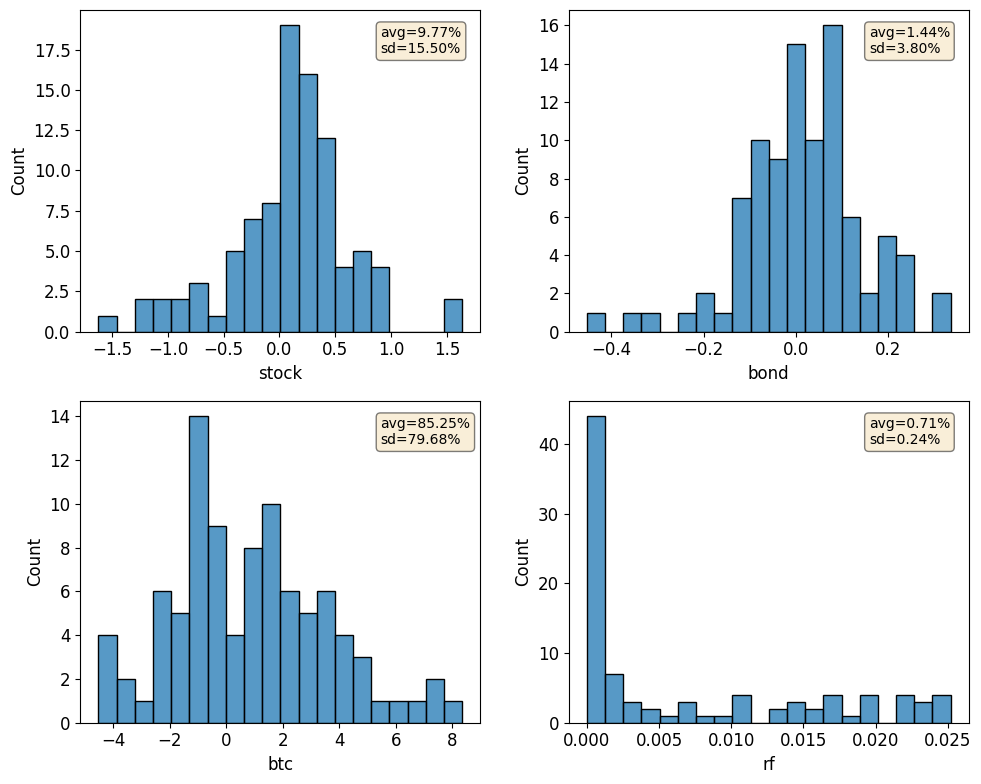

In [ ]:
# MVA
# read the date column into a 1-d array
dates_str_mva = np.genfromtxt(DATA_FILE_MVA,usecols=[0],skip_header=1,delimiter=',',dtype=str)

# read remaining columns into a 2-d array
rets_labs_mva = ['stock', 'bond', 'btc', 'rf']
prcs_mva = np.genfromtxt(DATA_FILE_MVA,usecols=np.arange(1,len(rets_labs_mva)+1),skip_header=1,
                         delimiter=',',dtype=float)

# create column labels for rets mva array
stock,bond,btc,rf = np.arange(len(rets_labs_mva))

# MVA
fig,ax=plt.subplots(2,2,figsize=(10,8))
ax=np.ravel(ax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i,l in enumerate(rets_labs_mva):
    ax[i]=sns.histplot(12*prcs_mva[:,i],ax=ax[i], bins = 20)
    ax[i].set_xlabel(l)
    # place a text box in upper right in axes coords
    txtstr = f"avg={12*prcs_mva[:,i].mean():.2%}\nsd={np.sqrt(12)*prcs_mva[:,i].std():.2%}"
    ax[i].text(0.75, 0.95, txtstr, transform=ax[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
plt.tight_layout()


## Annualized estimates

In [ ]:
columns = 0
for col in rets_labs_mva:
    print(f"{col}:"
        f"\n\tmean ~  {round(rets_mva[:,columns].mean() * MONTH_SCALE, 5)}"
        f"\n\tstd ~ {round(rets_mva[:,columns].std() * np.sqrt(MONTH_SCALE), 5)}"
        )
    columns+=1

stock:
	mean ~  0.09765
	std ~ 0.155
bond:
	mean ~  0.01436
	std ~ 0.03801
btc:
	mean ~  0.85245
	std ~ 0.79677
rf:
	mean ~  0.00714
	std ~ 0.00242


Text(0, 10, 'stock')

Text(0, 10, 'bond')

Text(0, 10, 'btc')

Text(0.5, 0, 'Standard Deviation')

Text(0, 0.5, 'Average Return')

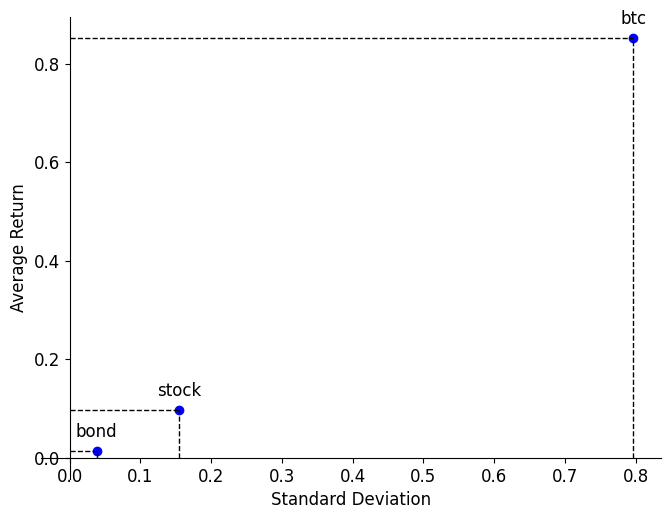

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
mu = 12*rets_mva.mean(axis=0)
sigma = np.sqrt(12)*rets_mva.std(axis=0)
for i,j in enumerate(rets_labs_mva[:3]):
    ax.plot(sigma[i],mu[i],marker='o',color='b')
    ax.annotate(j, # this is the text
            (sigma[i],mu[i]), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center
    ax.vlines(sigma[i],0,mu[i],linestyle='--',color='k',linewidth=1)
    ax.hlines(mu[i],0,sigma[i],linestyle='--',color='k',linewidth=1)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Average Return')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.show()

In [ ]:
columns = 0
for col in rets_labs_etf:
    print(f"{col}:"
        f"\n\tmean ~  {round(rets_etf[:,columns].mean() * DAY_SCALE, 5)}"
        f"\n\tstd ~ {round(rets_etf[:,columns].std() * np.sqrt(DAY_SCALE), 5)}"
        )
    columns+=1

bito:
	mean ~  -1.14651
	std ~ 0.68452
xbtf:
	mean ~  -1.13703
	std ~ 0.68354
btc:
	mean ~  -1.17487
	std ~ 0.6108


Text(0, 10, 'bito')

Text(0, 10, 'xbtf')

Text(0, 10, 'btc')

Text(0.5, 0, 'Standard Deviation')

Text(0, 0.5, 'Average Return')

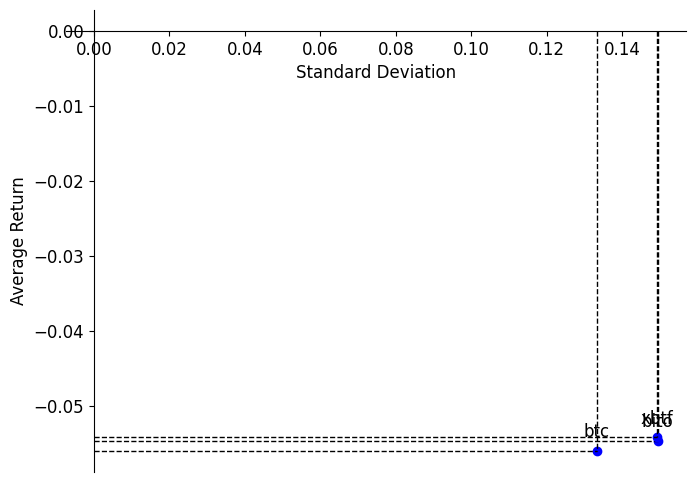

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
mu = 12*rets_etf.mean(axis=0)
sigma = np.sqrt(12)*rets_etf.std(axis=0)
for i,j in enumerate(rets_labs_etf[:3]):
    ax.plot(sigma[i],mu[i],marker='o',color='b')
    ax.annotate(j, # this is the text
            (sigma[i],mu[i]), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center
    ax.vlines(sigma[i],0,mu[i],linestyle='--',color='k',linewidth=1)
    ax.hlines(mu[i],0,sigma[i],linestyle='--',color='k',linewidth=1)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Average Return')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
plt.show()

### Histograms

Text(0.5, 1.0, 'bito')

Text(0.75, 0.95, 'avg=-114.65%\nsd=68.45%')

Text(0.5, 1.0, 'xbtf')

Text(0.75, 0.95, 'avg=-113.70%\nsd=68.35%')

Text(0.5, 1.0, 'btc')

Text(0.75, 0.95, 'avg=-117.49%\nsd=61.08%')

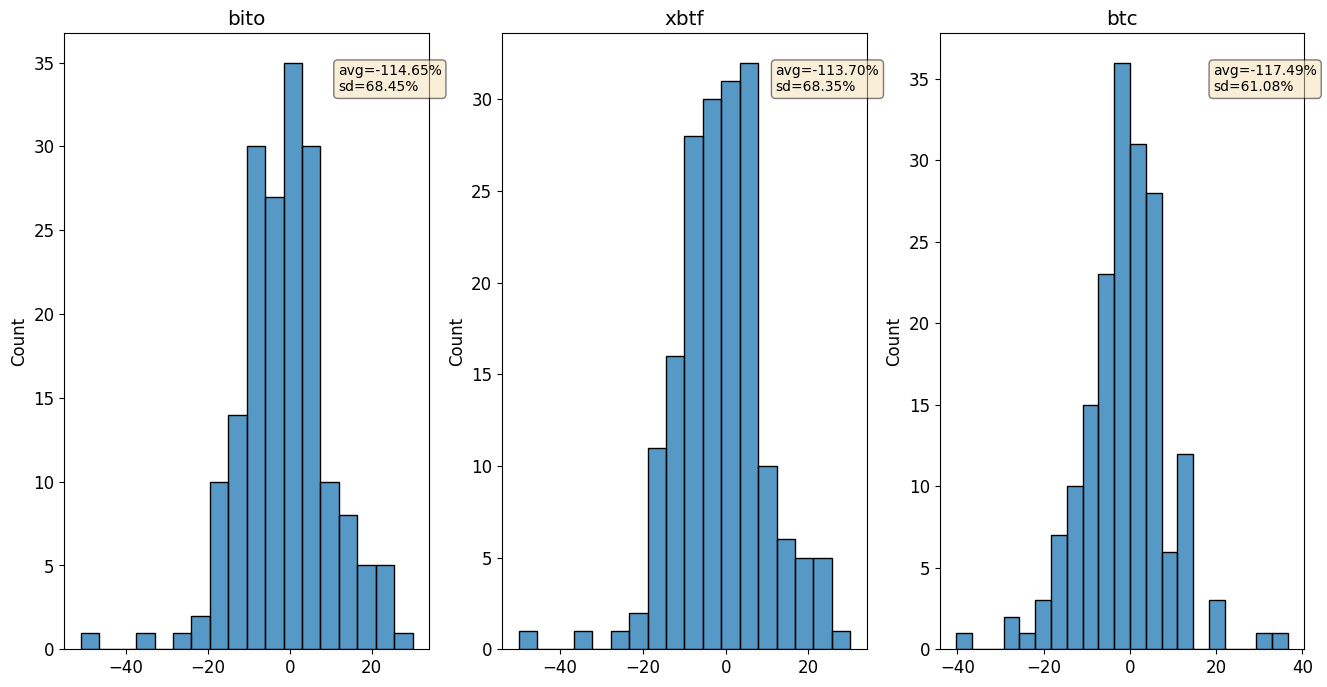

In [ ]:
# Annualized Returns
fig,ax=plt.subplots(1,3,figsize=(16,8))
ax=np.ravel(ax)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i in np.arange(rets_etf.shape[1]):
    ax[i] = sns.histplot(DAY_SCALE*rets_etf[:,i],ax=ax[i])
    ax[i].set_title(rets_labs_etf[i])
    # place a text box in upper right in axes coords
    txtstr = f"avg={DAY_SCALE*rets_etf[:,i].mean():.2%}\nsd={np.sqrt(DAY_SCALE)*rets_etf[:,i].std():.2%}"
    ax[i].text(0.75, 0.95, txtstr, transform=ax[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)


plt.show()

Text(0.5, 0, 'stock')

Text(0.75, 0.95, 'avg=9.77%\nsd=15.50%')

Text(0.5, 0, 'bond')

Text(0.75, 0.95, 'avg=1.44%\nsd=3.80%')

Text(0.5, 0, 'btc')

Text(0.75, 0.95, 'avg=85.25%\nsd=79.68%')

Text(0.5, 0, 'rf')

Text(0.75, 0.95, 'avg=0.71%\nsd=0.24%')

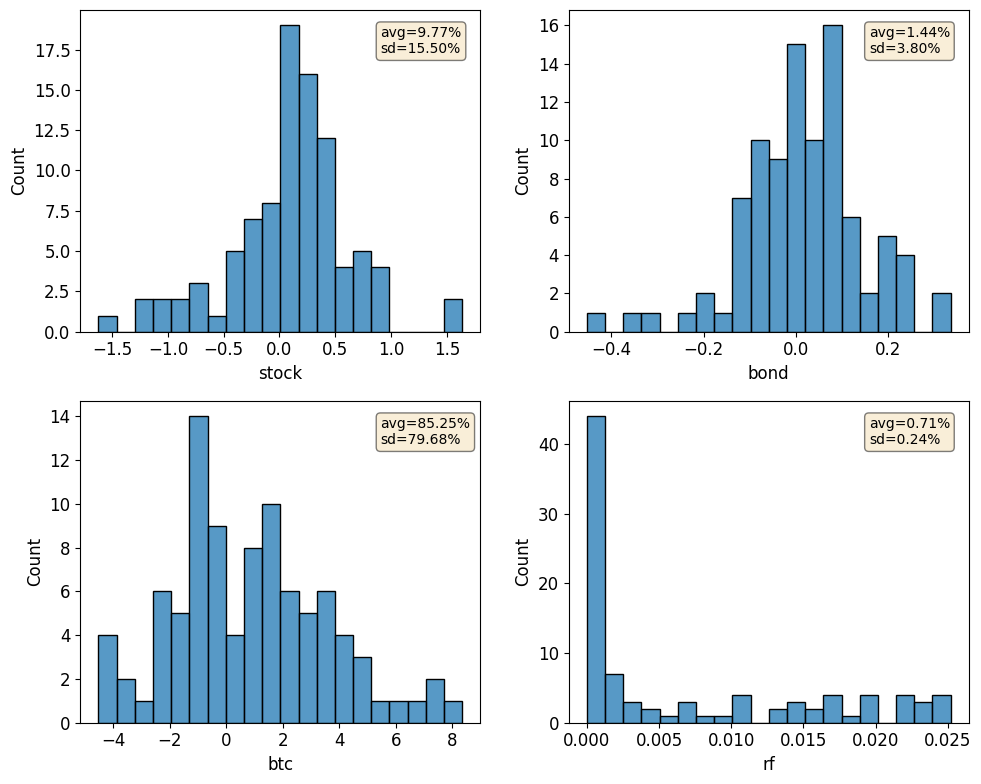

In [ ]:
# MVA
# read the date column into a 1-d array
dates_str_mva = np.genfromtxt(DATA_FILE_MVA,usecols=[0],skip_header=1,delimiter=',',dtype=str)

# read remaining columns into a 2-d array
rets_labs_mva = ['stock', 'bond', 'btc', 'rf']
prcs_mva = np.genfromtxt(DATA_FILE_MVA,usecols=np.arange(1,len(rets_labs_mva)+1),skip_header=1,
                         delimiter=',',dtype=float)

# create column labels for rets mva array
stock,bond,btc,rf = np.arange(len(rets_labs_mva))

# MVA
fig,ax=plt.subplots(2,2,figsize=(10,8))
ax=np.ravel(ax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i,l in enumerate(rets_labs_mva):
    ax[i]=sns.histplot(12*prcs_mva[:,i],ax=ax[i], bins = 20)
    ax[i].set_xlabel(l)
    # place a text box in upper right in axes coords
    txtstr = f"avg={12*prcs_mva[:,i].mean():.2%}\nsd={np.sqrt(12)*prcs_mva[:,i].std():.2%}"
    ax[i].text(0.75, 0.95, txtstr, transform=ax[i].transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
plt.tight_layout()


### Overlay Histograms

- When observing the overlayed histograms of bitcoin and the etfs, there seems to be little visual difference in the distribution of these three investments. The ETFs track Bitcoin's returns.
- When comparing bitcoin to non crypto indices, it is apprent that bitcoin has a much wider spread of returns than even the stock market.

Text(0.5, 0, 'Daily Return (%)')

Text(0.5, 0, 'Daily Return (%)')

Text(0.5, 0, 'Daily Return (%)')

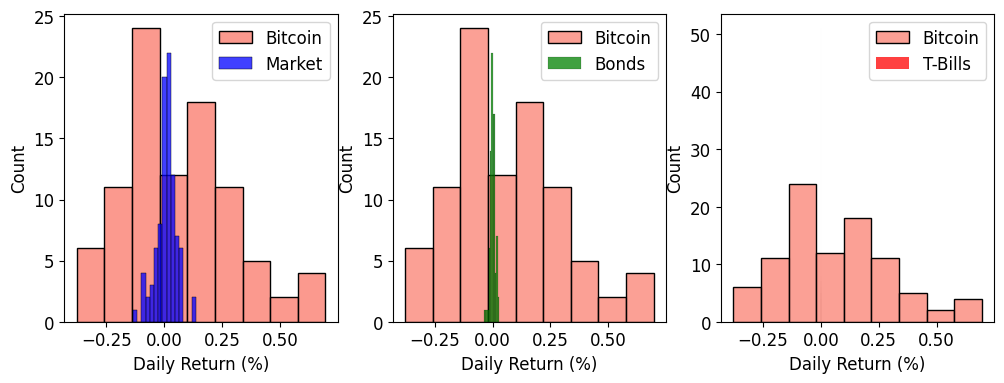

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

# BTC vs STOCK
ax1=sns.histplot(x=rets_mva[:,btc], kde=False, color='salmon', alpha=0.8, label='Bitcoin', ax=ax1)
ax1=sns.histplot(x=rets_mva[:,stock], kde=False, color='blue', label='Market', ax=ax1)
ax1.set_xlabel("Daily Return (%)")
ax1.legend()

# BTC vs BOND
ax2=sns.histplot(x=rets_mva[:,btc], kde=False, color='salmon', label='Bitcoin', ax=ax2)
ax2=sns.histplot(x=rets_mva[:,bond], kde=False, color='green', label='Bonds', ax=ax2)
ax2.set_xlabel("Daily Return (%)")
ax2.legend()

#BTC vs T-BILL
ax3=sns.histplot(x=rets_mva[:,btc], kde=False, color='salmon', label='Bitcoin', ax=ax3)
ax3=sns.histplot(x=rets_mva[:,rf], kde=False, color='red', label='T-Bills', ax=ax3)
ax3.set_xlabel("Daily Return (%)")
ax3.legend()

plt.show()

- When observing the overlayed histograms, there seems to be little visual difference in the distribution of these three investments. The ETFs track Bitcoin's returns.

Text(0.5, 0, 'Daily Return (%)')

Text(0.5, 0, 'Daily Return (%)')

Text(0.5, 0, 'Daily Return (%)')

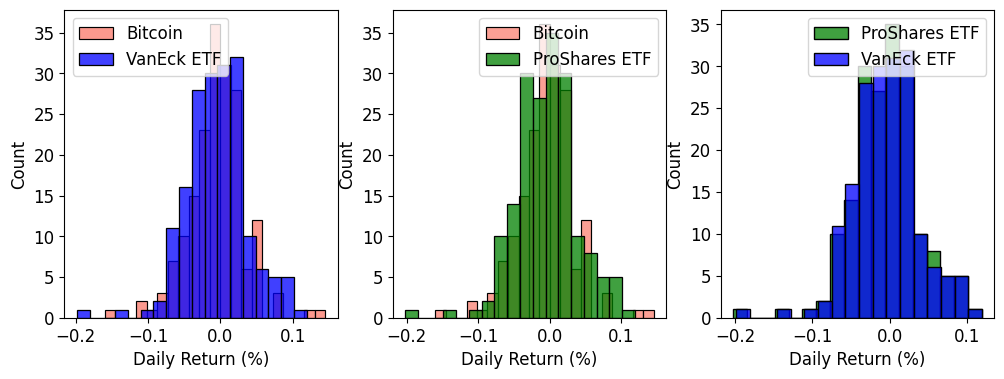

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

# BTC vs XBTF
ax1=sns.histplot(x=rets_etf[:,btc], kde=False, color='salmon', alpha=0.8, label='Bitcoin', ax=ax1)
ax1=sns.histplot(x=rets_etf[:,xbtf], kde=False, color='blue', label='VanEck ETF', ax=ax1)
ax1.set_xlabel("Daily Return (%)")
ax1.legend()

# BTC vs BITO
ax2=sns.histplot(x=rets_etf[:,btc], kde=False, color='salmon', label='Bitcoin', ax=ax2)
ax2=sns.histplot(x=rets_etf[:,bito], kde=False, color='green', label='ProShares ETF', ax=ax2)
ax2.set_xlabel("Daily Return (%)")
ax2.legend()

#BITO vs XBTF
ax3=sns.histplot(x=rets_etf[:,bito], kde=False, color='green', label='ProShares ETF', ax=ax3)
ax3=sns.histplot(x=rets_etf[:,xbtf], kde=False, color='blue', label='VanEck ETF', ax=ax3)
ax3.set_xlabel("Daily Return (%)")
ax3.legend()

plt.show()

### Time Series Plots

- When looking at bitcoin vs other indicies, the difference in varience is even more apperant.
- What was observed in the overlay of histograms when comparing bitcoin to etfs is even more apparent in the time series. Here we can see more clearly that the ETFs are heavily correlated with each other.

<Axes: >

<Axes: >

Text(0, 0.5, 'Daily Return (%)')

<Axes: >

<Axes: >

Text(0, 0.5, 'Daily Return (%)')

<Axes: >

<Axes: >

Text(0, 0.5, 'Daily Return (%)')

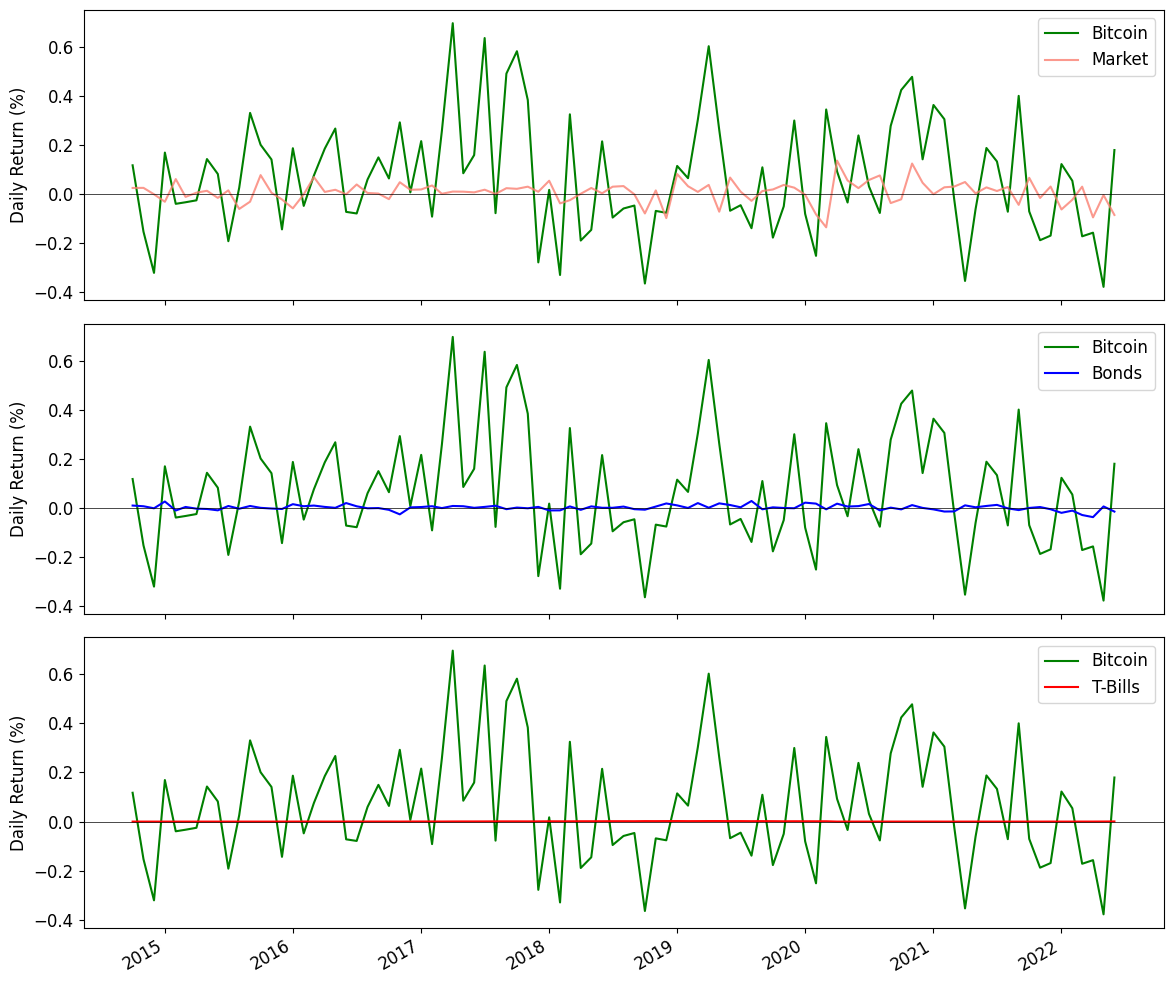

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# BTC vs STOCK
sns.lineplot(x=dates_mva, y=rets_mva[:, btc], label="Bitcoin", color='green', ax=ax1)
sns.lineplot(x=dates_mva, y=rets_mva[:, stock], label="Market", color='salmon', alpha=0.8, ax=ax1)
ax1.axhline(0, 0, 1, color='k', linewidth=.5)
ax1.set_ylabel("Daily Return (%)")

# # Set x-axis ticks and labels for ax1
# ax1.xaxis.set_major_locator(mdates.MonthLocator())
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# BTC vs BONDS
sns.lineplot(x=dates_mva, y=rets_mva[:, btc], label="Bitcoin", color='green', ax=ax2)
sns.lineplot(x=dates_mva, y=rets_mva[:, bond], label="Bonds", color='b', ax=ax2)
ax2.axhline(0, 0, 1, color='k', linewidth=.5)
ax2.set_ylabel("Daily Return (%)")

# # Set x-axis ticks and labels for ax2
# ax2.xaxis.set_major_locator(mdates.MonthLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# XBTF vs T-BILLS
sns.lineplot(x=dates_mva, y=rets_mva[:, btc], label="Bitcoin", color='green', ax=ax3)
sns.lineplot(x=dates_mva, y=rets_mva[:, rf], label="T-Bills", color='red', ax=ax3)
ax3.axhline(0, 0, 1, color='k', linewidth=.5)
ax3.set_ylabel("Daily Return (%)")

# # Set x-axis ticks and labels for ax3
# ax3.xaxis.set_major_locator(mdates.MonthLocator())
# ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


fig.autofmt_xdate()  # Rotate and align the x labels
plt.tight_layout()
plt.show()


- What was observed in the overlay of histograms is even more apparent in the time series. Here we can see more clearly that the ETFs are heavily correlated with each other.

<Axes: >

<Axes: >

Text(0, 0.5, 'Daily Return (%))')

<Axes: >

<Axes: >

Text(0, 0.5, 'Daily Return (%))')

<Axes: >

<Axes: >

Text(0, 0.5, 'Daily Return (%))')

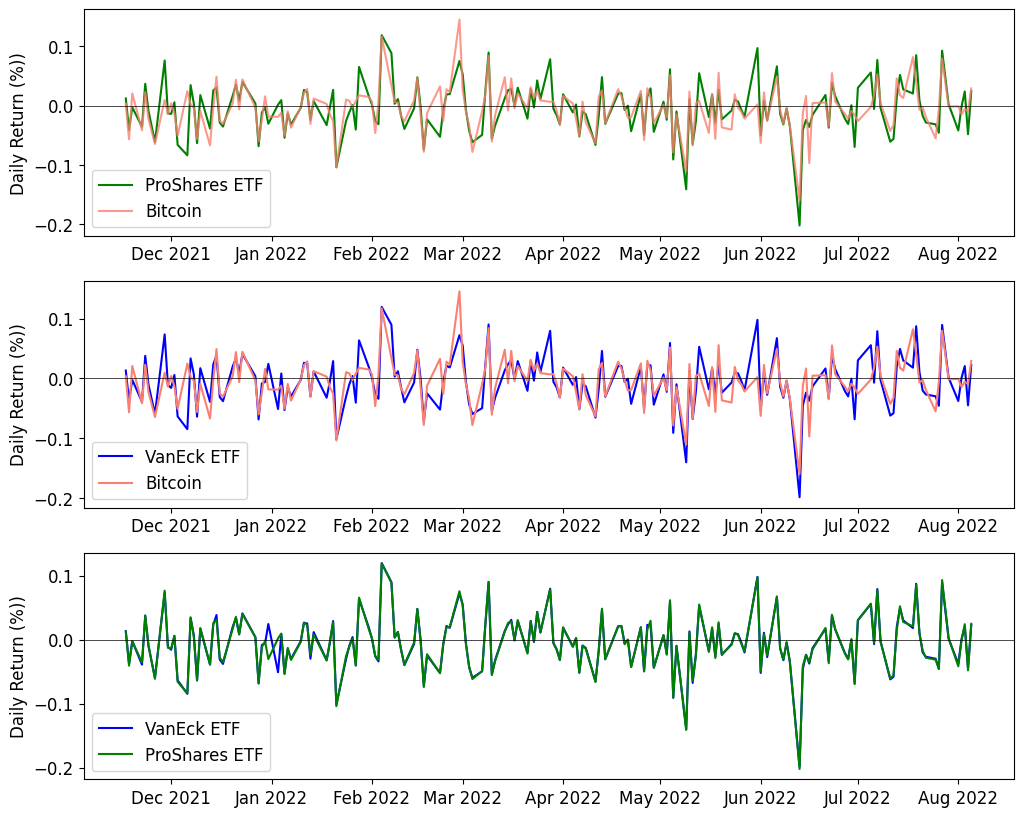

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,10))

# BTC vs BITO
sns.lineplot(x=dates_etf, y=rets_etf[:,bito], label="ProShares ETF", color='green', ax=ax1)
sns.lineplot(x=dates_etf, y=rets_etf[:,btc], label="Bitcoin", color='salmon', alpha=0.8, ax=ax1)
ax1.axhline(0,0,1,color='k',linewidth=.5)
ax1.set_ylabel("Daily Return (%))")

# Set x-axis ticks and labels for ax1
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# BTC vs XBTF
sns.lineplot(x=dates_etf, y=rets_etf[:,xbtf], label="VanEck ETF", color='b', ax=ax2)
sns.lineplot(x=dates_etf, y=rets_etf[:,btc], label="Bitcoin", color='salmon', ax=ax2)
ax2.axhline(0,0,1,color='k',linewidth=.5)
ax2.set_ylabel("Daily Return (%))")

# Set x-axis ticks and labels for ax1
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# XBTF vs BITO
sns.lineplot(x=dates_etf, y=rets_etf[:,xbtf], label="VanEck ETF", color='b', ax=ax3)
sns.lineplot(x=dates_etf, y=rets_etf[:,bito], label="ProShares ETF", color='green', ax=ax3)
ax3.axhline(0,0,1,color='k',linewidth=.5)
ax3.set_ylabel("Daily Return (%))")

# Set x-axis ticks and labels for ax1
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))



plt.show()

### Correlations

#### Comparing Bitcoin to ETFs
- Putting some numbers to these correlations, we find that the ETFs are almost 100% correlated with each other, confirming our previous suspicions from earlier graphs.
- Both ETFs have an 80% correlation with Bitcoin returns.

#### Comparing Bitcoin to the Market, Bonds, and T-Bills
- Bitcoin has a weakly negative correlation with bonds & t-bills and a weakly positive correlation with the market.
- Though they track over a shorter time horizon, it is fair to assume that the EFTs would have similar correlations to the market, bonds, and t-bills since they track/reflect bitcoin returns so closely

[[1.     0.9901 0.7988]
 [0.9901 1.     0.795 ]
 [0.7988 0.795  1.    ]]


<Axes: >

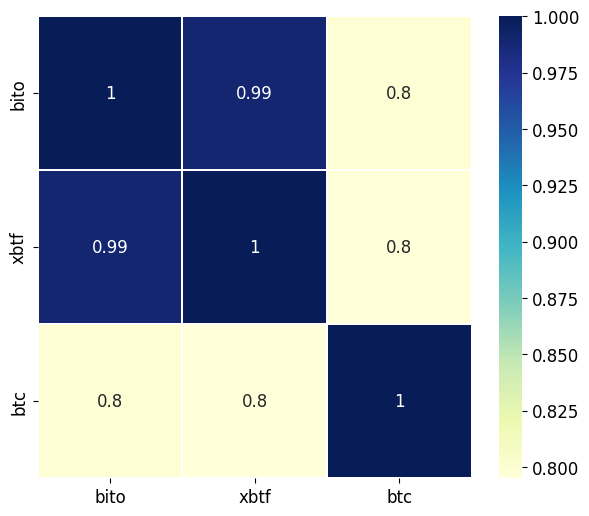

In [ ]:
# get the correlation matrix for our return series
corrmat = np.corrcoef(rets_etf,rowvar=False)
print(corrmat)
# Create a heatmap to visualize the correlation matrix (easeier to read)
f, ax = plt.subplots(figsize =(7, 6))
sns.heatmap(corrmat, annot=True,
            ax = ax, cmap ="YlGnBu",
            xticklabels=rets_labs_etf,
            yticklabels=rets_labs_etf,
            linewidths = 0.1)

plt.show()

[[ 1.      0.1202  0.0574 -0.1286]
 [ 0.1202  1.     -0.0033  0.2199]
 [ 0.0574 -0.0033  1.     -0.0314]
 [-0.1286  0.2199 -0.0314  1.    ]]


<Axes: >

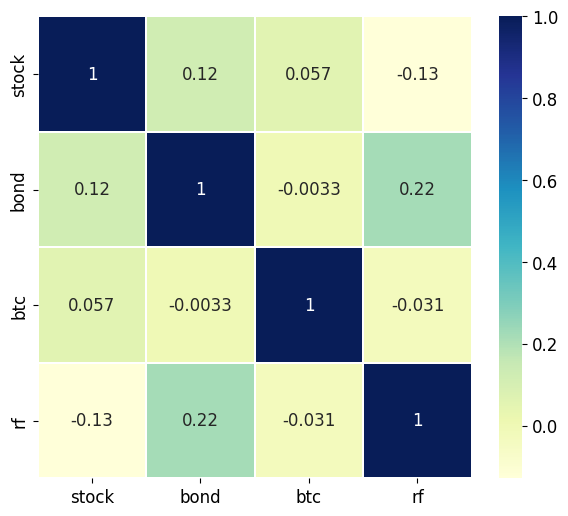

In [ ]:
# get the correlation matrix for our return series
corrmat = np.corrcoef(rets_mva,rowvar=False)
print(corrmat)
# Create a heatmap to visualize the correlation matrix (easeier to read)
f, ax = plt.subplots(figsize =(7, 6))
sns.heatmap(corrmat, annot=True,
            ax = ax, cmap ="YlGnBu",
            xticklabels=rets_labs_mva,
            yticklabels=rets_labs_mva,
            linewidths = 0.1)

plt.show()

### Persistence

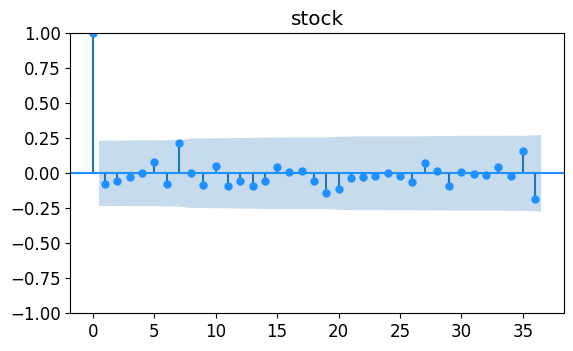

Text(0.7, 0.95, 'AR(1): -0.08')

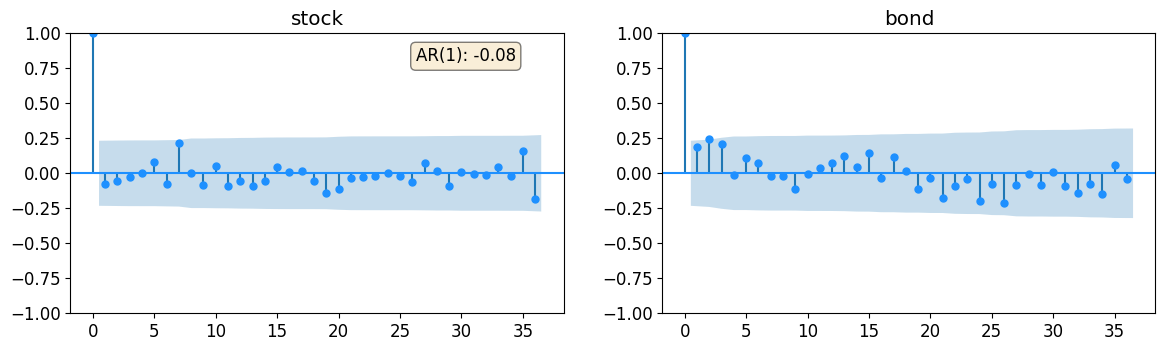

Text(0.7, 0.95, 'AR(1): 0.19')

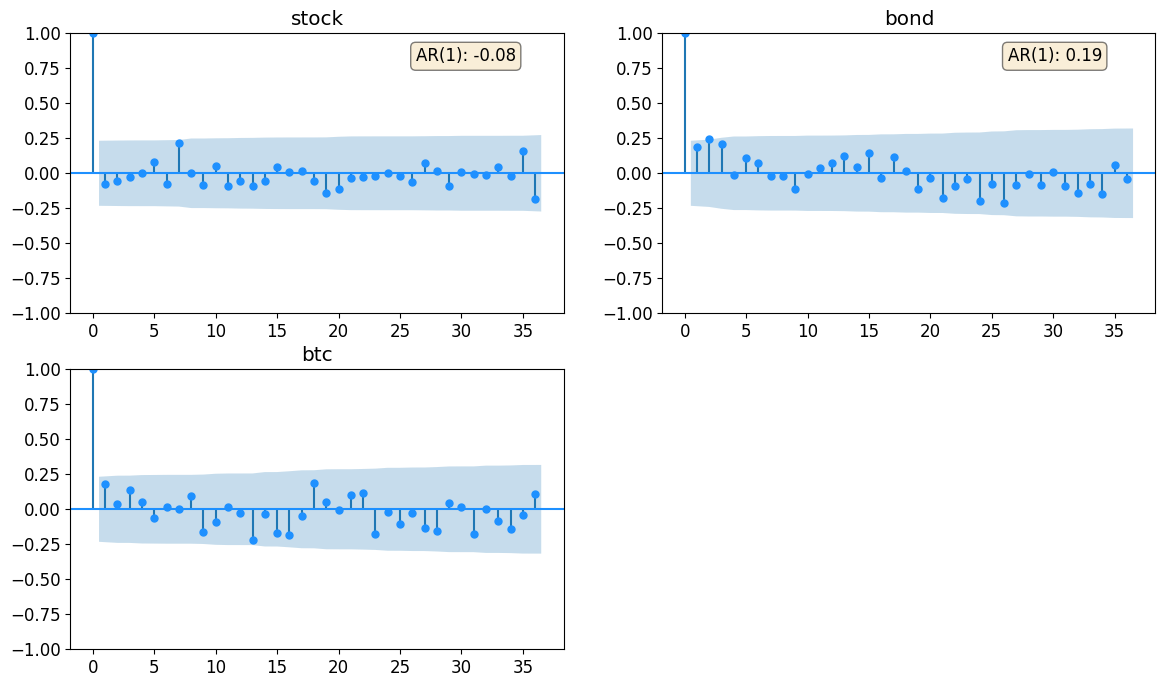

Text(0.7, 0.95, 'AR(1): 0.18')

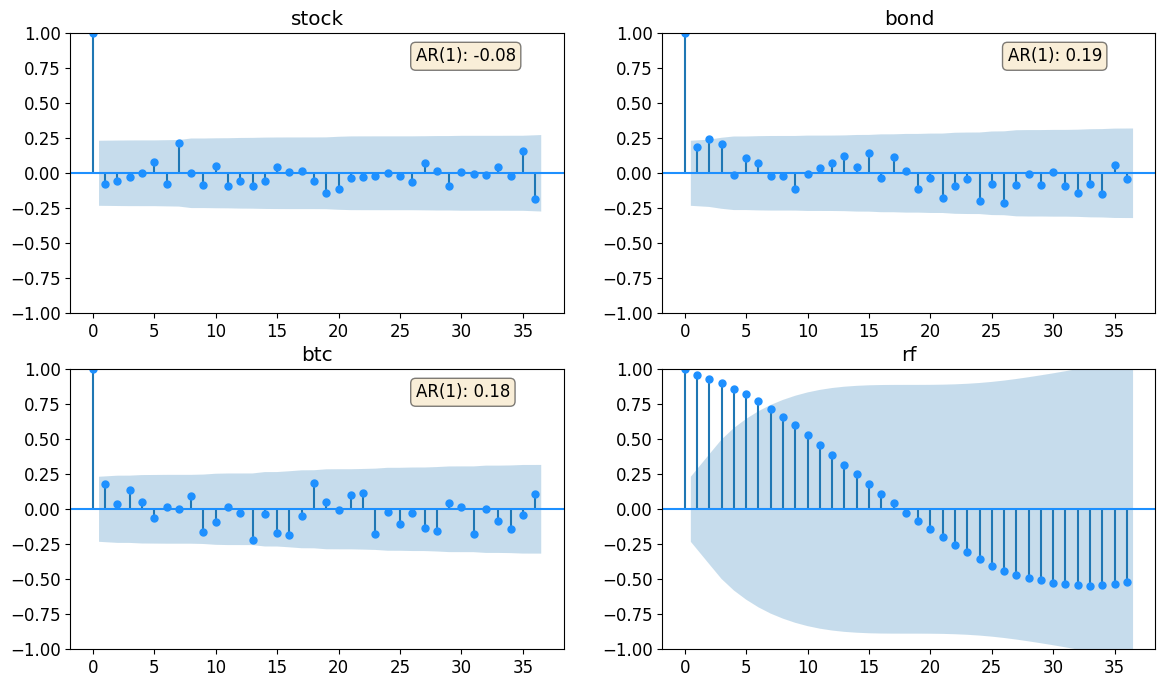

Text(0.7, 0.95, 'AR(1): 0.96')

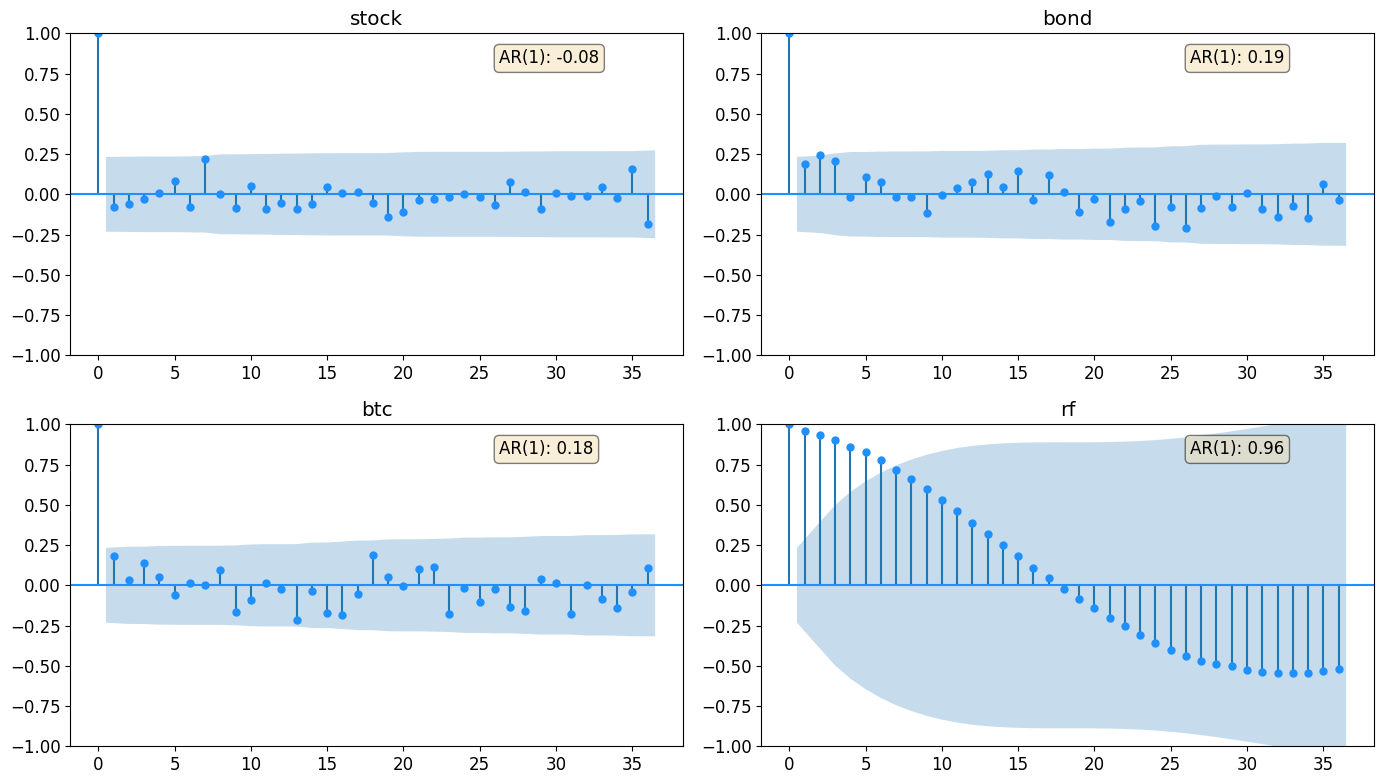

In [ ]:
fig = plt.figure(figsize=(14,8))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Figure counter: 130 --> 1x3 grid
iplot = 220
for i in np.arange(4):
    iplot += 1                   # increment to tell matplotlib where to place the subplot
    ax = fig.add_subplot(iplot)  # add a subplot in position `iplot`
    sm.graphics.tsa.plot_acf(rets_mva[:,i], lags=36, alpha=0.025,
                         ax=ax, title=rets_labs_mva[i], color='dodgerblue') #ACF function

    ar1 = np.corrcoef((rets_mva[1:,i], rets_mva[:-1,i]))[0,1] #autocorrelation of the series
    textstr = f"AR(1): {ar1:.2f}"
    ax.text(0.70, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


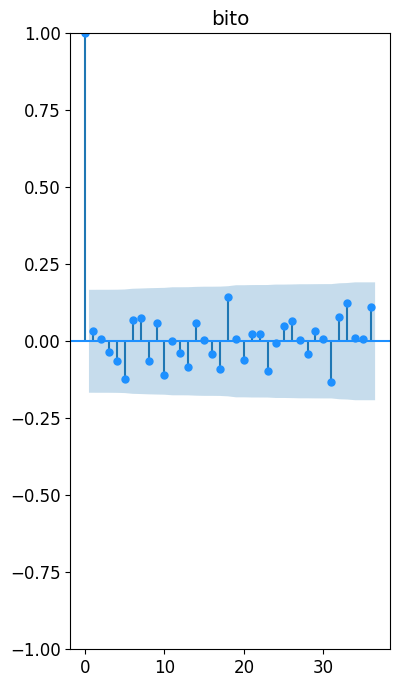

Text(0.7, 0.95, 'AR(1): 0.03')

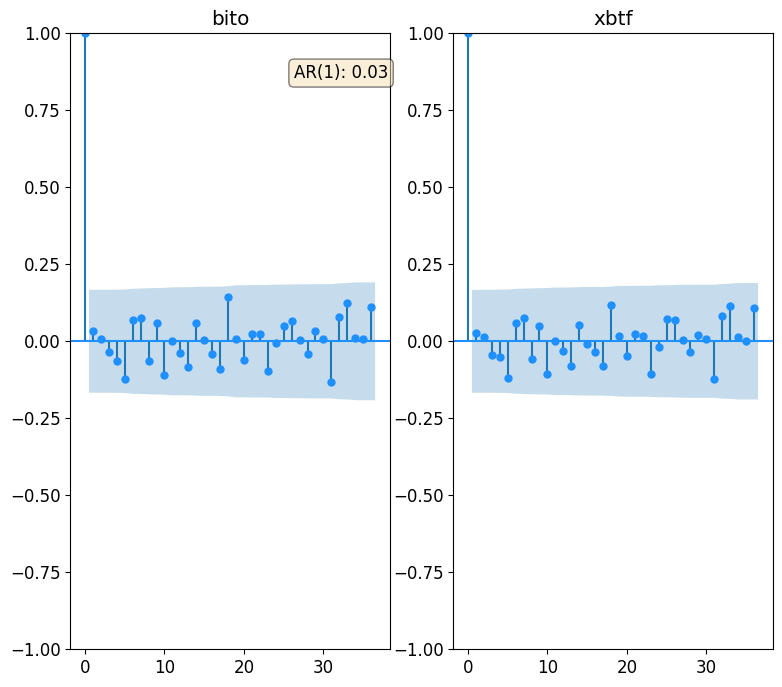

Text(0.7, 0.95, 'AR(1): 0.03')

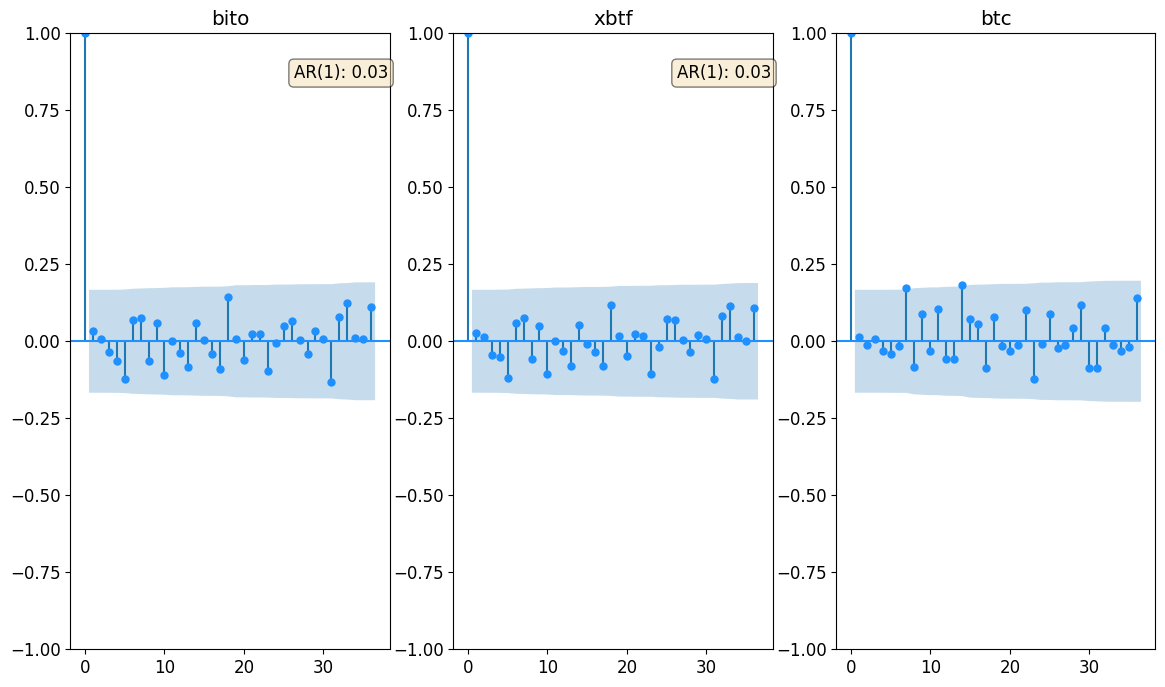

Text(0.7, 0.95, 'AR(1): 0.02')

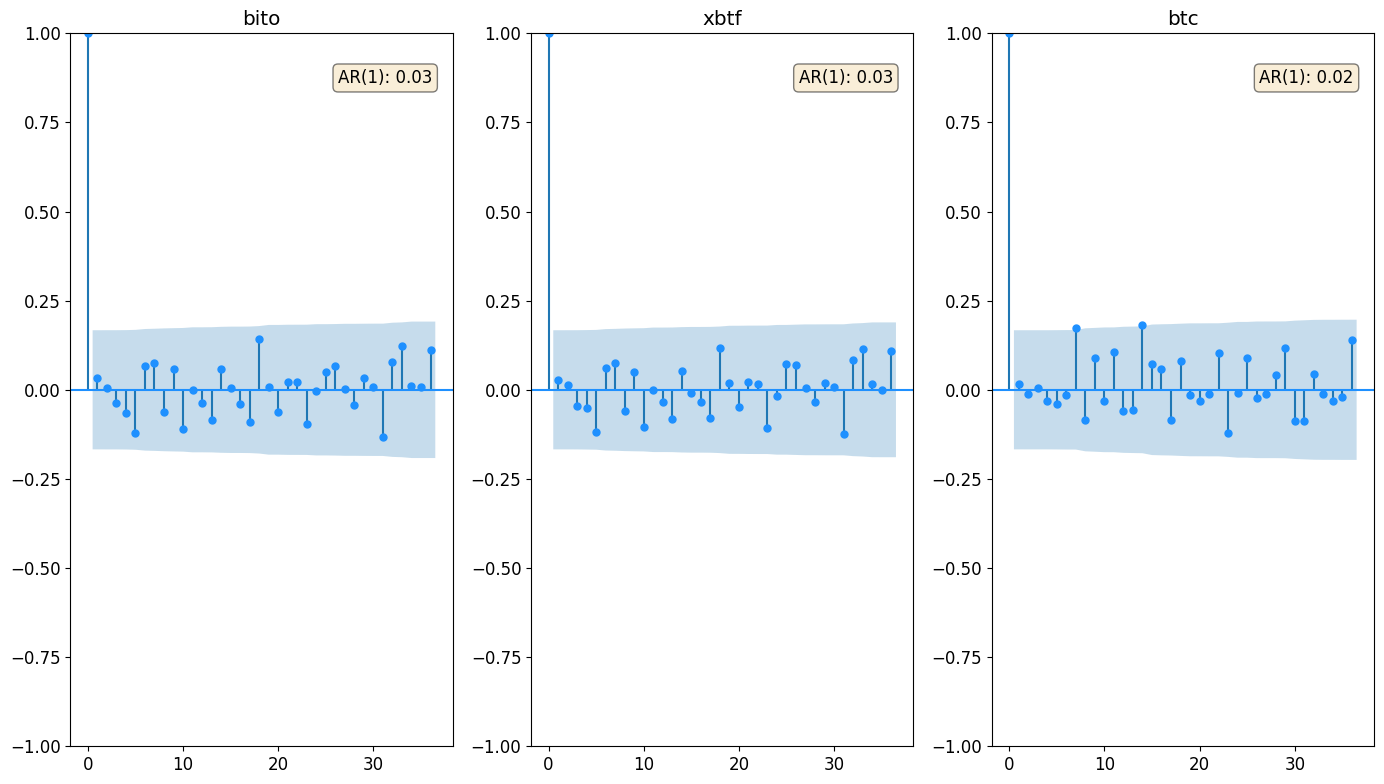

In [ ]:
fig = plt.figure(figsize=(14,8))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Figure counter: 130 --> 1x3 grid
iplot = 130
for i in np.arange(3):
    iplot += 1                   # increment to tell matplotlib where to place the subplot
    ax = fig.add_subplot(iplot)  # add a subplot in position `iplot`
    sm.graphics.tsa.plot_acf(rets_etf[:,i], lags=36, alpha=0.025,
                         ax=ax, title=rets_labs_etf[i], color='dodgerblue') #ACF function

    ar1 = np.corrcoef((rets_etf[1:,i], rets_etf[:-1,i]))[0,1] #autocorrelation of the series
    textstr = f"AR(1): {ar1:.2f}"
    ax.text(0.70, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


# Advanced Analysis

### Portfolio Performance

- Even when compared to the market, Bitcoin far outperforms in returns over the seven year period. Using a linear y-axis drastically emphasizes the difference.

- Comparing the portfolio performance of bitcoin and the etfs to the longer time horizon of the mva dataset, it's apparent that the period of our ETF data tracks the extended period of downfall for Bitcoin. Much of our investment decision will be dependent on our belief on if the downturn will persist. As we already established (and will continue to dive into further), Bitcoin has a very weak correlation with the market, so our assessment on its future growth is completely based on our trust in it independently.

Text(0.5, 1.0, 'Portfolio Value of $1 investment')

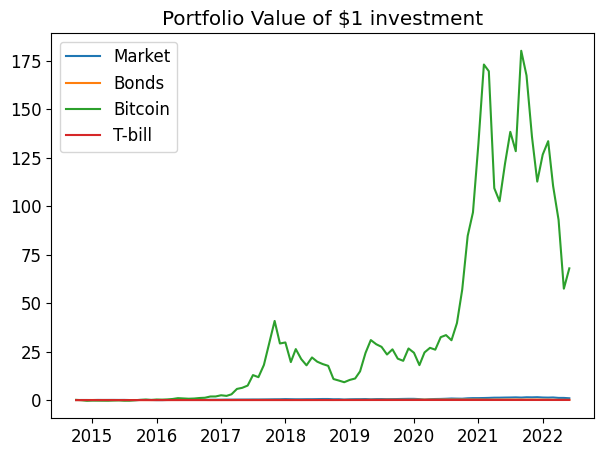

In [ ]:
# Bitcoin vs Market, Bonds, and T-Bills
d = (1+rets_mva[:,[stock,bond,btc,rf]]).cumprod(axis=0) - 1

fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.plot(dates_mva,d[:,0],label='Market')
ax.plot(dates_mva,d[:,1],label='Bonds')
ax.plot(dates_mva,d[:,2],label='Bitcoin')
ax.plot(dates_mva,d[:,3],label='T-bill')
ax.set_title("Portfolio Value of $1 investment")
ax.legend()
ax.grid(False)
plt.show()

Text(0.5, 1.0, 'Portfolio Value of $1 investment')

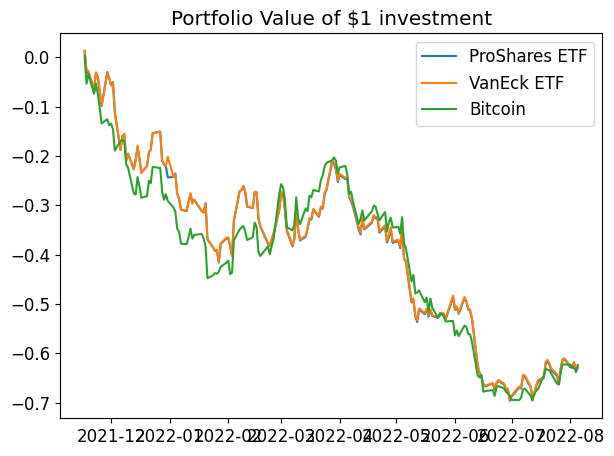

In [ ]:
# Bitcoin vs ETFs
d = (1+rets_etf[:,[bito,xbtf,btc]]).cumprod(axis=0) - 1

fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.plot(dates_etf,d[:,0],label='ProShares ETF')
ax.plot(dates_etf,d[:,1],label='VanEck ETF')
ax.plot(dates_etf,d[:,2],label='Bitcoin')
ax.set_title("Portfolio Value of $1 investment")
ax.legend()
ax.grid(False)
plt.show()

## Wealth indices

- By breaking down the portfolio value of a dollar into wealth indicies, we can more easily compare the trends in returns of bitcoin to other investments.
- At a glance it seems as though bitcoin follows a vaguely similar path to the stock and bond markets, however it reacts at a greater magnitude. Overall it seems as though it is reeling back from the 2021 spike move volatily than the stock market. The question becomes whether or not the crypto currency is currently fairly priced, i.e. it has recovered from what clearly seemed to be a period of overestimating its value.

Text(0.5, 0, 'stock')

Text(0.5, 0, 'bond')

Text(0.5, 0, 'btc')

Text(0.5, 0, 'rf')

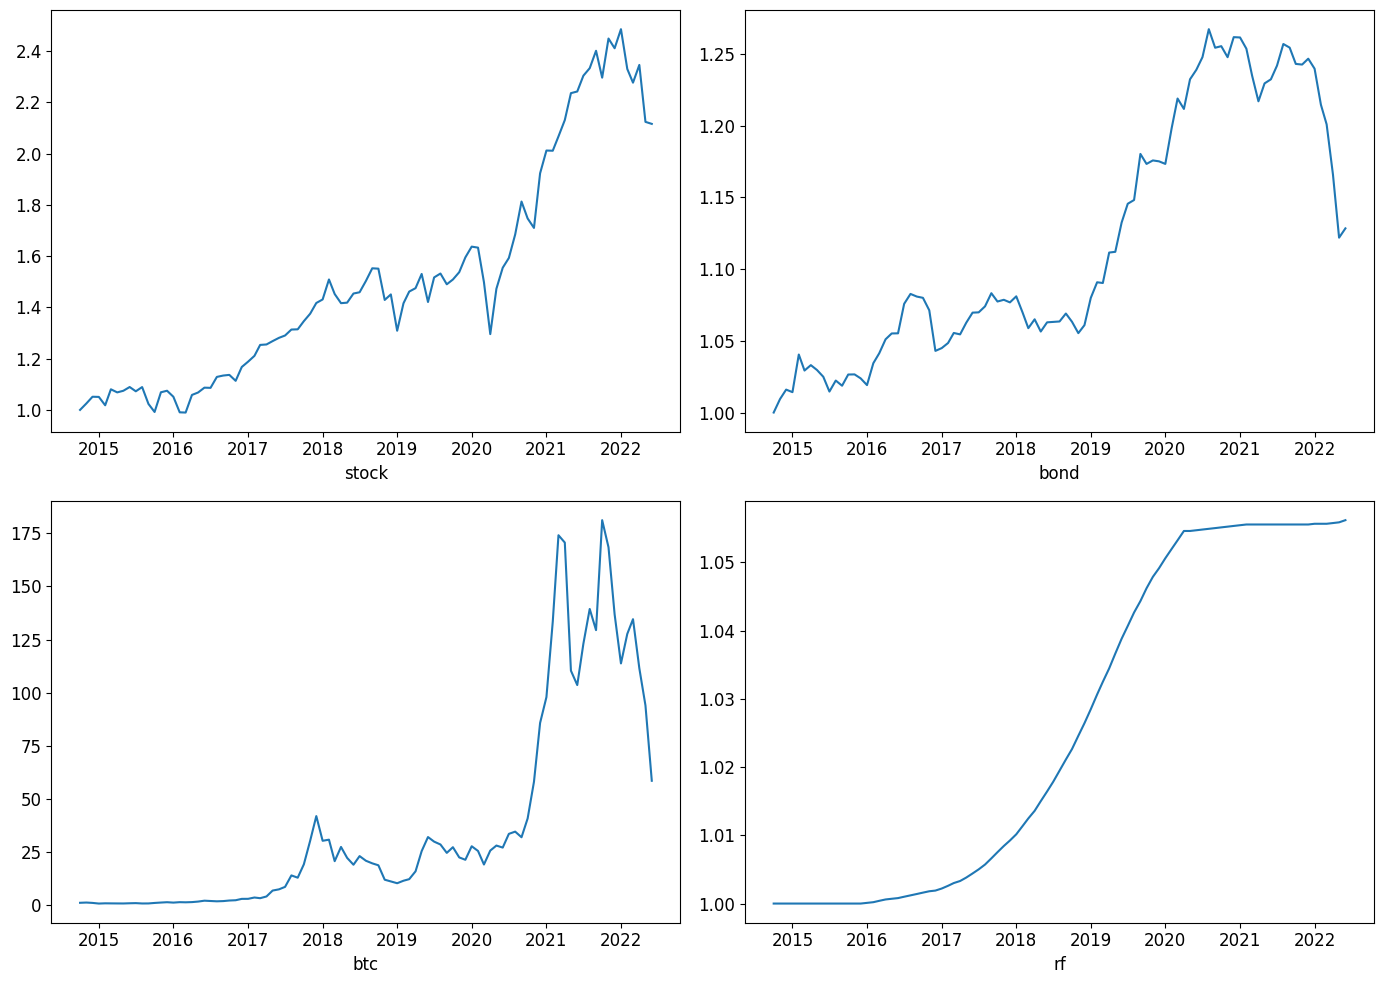

In [ ]:
# Bitcoin vs Market, Bonds, and T-Bills
wealth = np.ones((rets_mva.shape[0]+1,rets_mva.shape[1]))
for i in np.arange(rets_mva.shape[1]):
    wealth[1:,i] = np.cumprod(1+rets_mva[:,i])

fig, ax = plt.subplots(2,2,figsize=(14,10))
ax = np.ravel(ax)
for i,c in enumerate(np.arange(rets_mva.shape[1])):
    ax[i] = sns.lineplot(x=dates_mva,y=wealth[:-1,i],ax=ax[i])
    ax[i].set_xlabel(rets_labs_mva[i])

plt.tight_layout()
plt.show()

Text(0.5, 0, 'bito')

Text(0.5, 0, 'xbtf')

Text(0.5, 0, 'btc')

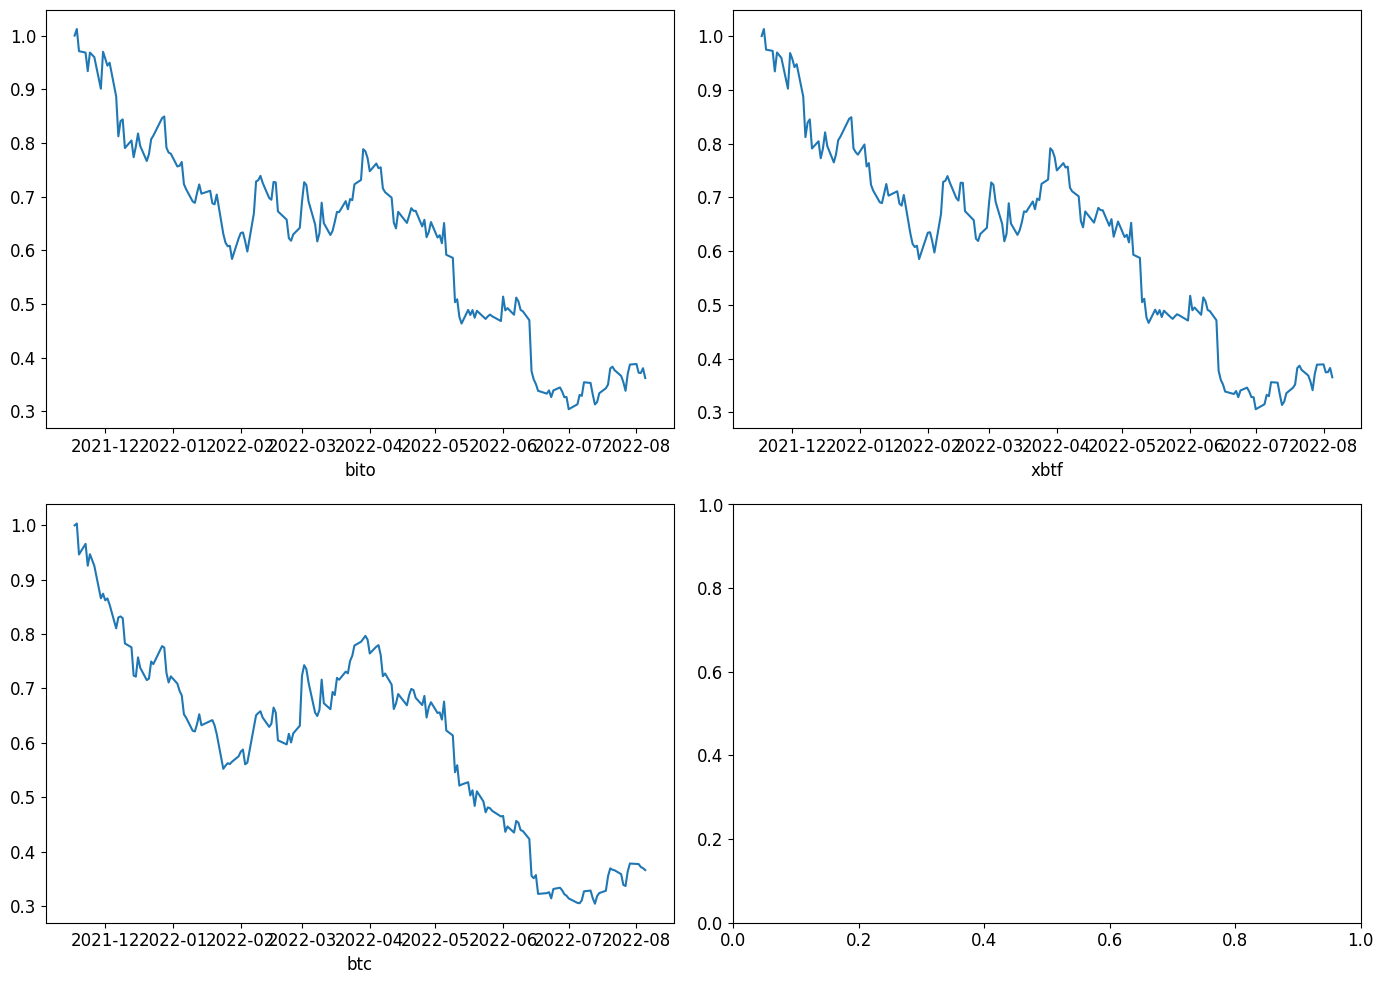

In [ ]:
# Bitcoin vs ETFs
wealth = np.ones((rets_etf.shape[0]+1,rets_etf.shape[1]))
for i in np.arange(rets_etf.shape[1]):
    wealth[1:,i] = np.cumprod(1+rets_etf[:,i])

fig, ax = plt.subplots(2,2,figsize=(14,10))
ax = np.ravel(ax)
for i,c in enumerate(np.arange(rets_etf.shape[1])):
    ax[i] = sns.lineplot(x=dates_etf,y=wealth[:-1,i],ax=ax[i])
    ax[i].set_xlabel(rets_labs_etf[i])

plt.tight_layout()
plt.show()

### Loss Probability

- As we already established, bitcoin is far more vo

In [ ]:
# Bitcoin vs Market, Bonds, and T-bills
loss = (rets_mva[:,[stock,bond,btc,rf]] < 0)
ploss = loss.mean(axis=0)
print(f"Pr(Market Loss): {ploss[0]:.3%}, Pr(Bond Loss): {ploss[1]:.3%}, Pr(Bitcoin Loss): {ploss[2]:.3%}, Pr(T-bill Loss): {ploss[2]:.3%}")

# ETF vs Bitcoin
loss = (rets_etf[:,[bito,xbtf,btc]] < 0)
ploss = loss.mean(axis=0)
print(f"Pr(ProShares ETF Loss): {ploss[0]:.3%}, Pr(VanEck ETF Loss): {ploss[1]:.3%}, Pr(Bitcoin Loss): {ploss[2]:.3%}")

Pr(Market Loss): 33.333%, Pr(Bond Loss): 43.011%, Pr(Bitcoin Loss): 44.086%, Pr(T-bill Loss): 44.086%
Pr(ProShares ETF Loss): 55.000%, Pr(VanEck ETF Loss): 55.556%, Pr(Bitcoin Loss): 54.444%


### Expected Return Conditional on Loss

In [ ]:
# Bitcoin vs Market, Bonds, and T-bills
for v in [stock,bond,btc,rf]:
    loss = rets_mva[:,v] < 0 #Points where the return is less than zero
    eloss_loss = rets_mva[loss,v].mean()
    print(f"E({rets_labs_mva[v]}|loss): {eloss_loss:.2%}")


# Bitcoin vs ETF
for v in [bito,xbtf,btc]:
    loss = rets_etf[:,v] < 0
    eloss_loss = rets_etf[loss,v].mean()
    print(f"E({rets_labs_etf[v]}|loss): {eloss_loss:.2%}")

E(stock|loss): -3.86%
E(bond|loss): -0.81%
E(btc|loss): -13.38%
E(rf|loss): nan%
E(bito|loss): -3.37%
E(xbtf|loss): -3.36%
E(btc|loss): -3.01%


<ipython-input-523-fab740e9ef84>:4: RuntimeWarning: Mean of empty slice.
  eloss_loss = rets_mva[loss,v].mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Sharpe ratios

\begin{eqnarray}
    \text{Sharpe ratio} = \frac{\mu_i - r_f}{\sigma_i}
\end{eqnarray}

where
- $\mu_i = E(r_i)$ is the expected return on asset $i$
- $r_f$ is the risk-free return
- $\sigma_i = SD(r_i)$ is the volatility (a.k.a., standard deviation) of asset $i$.

In [ ]:
# BTC
vdict = {
    'Bitcoin': btc,
    'Market': stock,
}

print(vdict)
for k,v in vdict.items():
    mu = rets_mva[:,v].mean()*12
    sd = rets_mva[:,v].std()*np.sqrt(12)
    sr = ((rets_mva[:,v] - rets_mva[:,rf]).mean() / rets_mva[:,v].std())*np.sqrt(12)
    print(f"{k} Annual Estimates:")
    print(f"  Average return: {mu:,.2%} (sd = {sd:,.2%})")
    print(f"  Sharpe ratio: {sr:,.2f}")

{'Bitcoin': 2, 'Market': 0}
Bitcoin Annual Estimates:
  Average return: 85.25% (sd = 79.68%)
  Sharpe ratio: 1.06
Market Annual Estimates:
  Average return: 9.77% (sd = 15.50%)
  Sharpe ratio: 0.58


## CAPM

The security market line implies:

\begin{equation}
    E(R_i) = R_f + \beta \left(E(R_m) - R_f \right)
\end{equation}

The regression version that we will estimate is:

\begin{equation}
    (r_t - r^f_t) = \alpha + \beta_1 (r^m_t - r^f_t) + \beta_1 (r^m_{t-1} - r^f_{t-1}) + \varepsilon_t
\end{equation}

where $r_t$ is the return to FuMark II in month $t$,
$r^f_t$ is the risk-free return in month $t$ (as proxied by the 30 T-bill yield), and
$r^m_t$ is the market return in month $t$ (as proxied by the CRSP value-weighted index). We include the one month lag excess return to account for potential asynchronous trading implications (see [Dimson (JFE, 1979) - Risk measurement when shares are subject to infrequent trading](https://www.sciencedirect.com/science/article/pii/0304405X79900138))


The implied market beta is the sum of $\beta_1$ and $\beta_2$.

In [ ]:
# Regression Variables
y  = rets_mva[1:,btc] - rets_mva[1:,rf]
const = np.ones(y.shape[0])
x1 = rets_mva[1:,stock] - rets_mva[1:,rf]
x2 = rets_mva[:-1,stock] - rets_mva[:-1,rf]
xmat = np.stack((const,x1,x2),axis=1)

<Axes: >

Text(0, 0.5, 'Bitcoin Excess Return')

Text(0.5, 0, 'Market Excess Return')

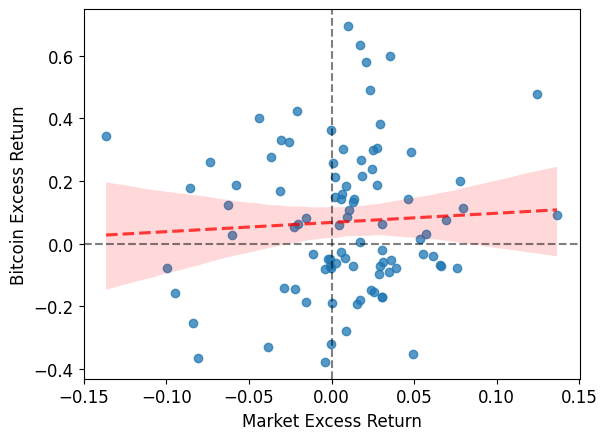

In [ ]:
# Visualize Data
fig,ax=plt.subplots(1,1)
sns.regplot(x=x1,y=y,ax=ax,
            scatter_kws={'alpha':.75},
            line_kws={'color':'r','linestyle':'--','alpha':0.75})
ax.set_ylabel("Bitcoin Excess Return")
ax.set_xlabel("Market Excess Return")
ax.axvline(0,0,1,color='k',linestyle='--',alpha=0.5)
ax.axhline(0,0,1,color='k',linestyle='--',alpha=0.5)

plt.show()

In [ ]:
#CAPM Regression
res = sm.OLS(y,xmat).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.1514
Date:                Thu, 22 Feb 2024   Prob (F-statistic):              0.860
Time:                        04:57:03   Log-Likelihood:                 4.3355
No. Observations:                  92   AIC:                            -2.671
Df Residuals:                      89   BIC:                             4.894
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0682      0.025      2.696      0.0

In [ ]:
alpha = res.params[0]
beta = res.params[1:].sum()
print(f"Alpha = {alpha:.2%}, Market beta = {beta:.4f}")
print(f"Annual alpha = {alpha*12:.2%}")

Alpha = 6.82%, Market beta = 0.2387
Annual alpha = 81.89%


In [ ]:
means_mva = prcs_mva.mean(0)
vols_mva  = prcs_mva.std(0,ddof=1)

# means
mu_1, mu_2, mu_3, mu_rf = means_mva*MONTH_SCALE
# volatilities
s_1, s_2, s_3, _        = vols_mva*np.sqrt(MONTH_SCALE)
# correlation
corr              = np.corrcoef(rets_mva[:,[stock,bond]],rowvar=False)[1,0]


In [ ]:
def create_tangency_portfolio(mu_1, mu_2, mu_rf, s_1, s_2, corr, name_1, name_2):

    w_1 = np.linspace(-0.5,1.5)         # stock #1 weight. Number of samples to generate is 50 by default (like here).
    w_2 = 1 - w_1                       # second asset weight ## THEY NEED TO SUM UP TO 1

    pret_mvf = w_1*mu_1 + w_2*mu_2      # portfolio expected return

    # portfolio volatility
    pvol_mvf = (
        np.sqrt(
            (w_1*s_1)**2
            + (w_2*s_2)**2
            + 2*w_1*w_2*s_1*s_2*corr
        )
    )

    w_1_mvp = (s_2**2 - s_1*s_2*corr) / (s_1**2 + s_2**2 - 2*s_1*s_2*corr)
    w_2_mvp = 1 - w_1_mvp
    pret_mvp = w_1_mvp * mu_1 + w_2_mvp * mu_2
    pvol_mvp = (
        np.sqrt(
            (w_1_mvp*s_1)**2
            + (w_2_mvp*s_2)**2
            + 2*w_1_mvp*w_2_mvp*s_1*s_2*corr
        )
    )

    print("MVP: Portfolio Weights")
    print(f" {name_1}   {name_2}")
    print(f"{w_1_mvp:.4f} {w_2_mvp:.4f}")
    print(f"Expected return: {pret_mvp:.4f}")
    print(f"Volatility: {pvol_mvp:.4f}")

    w_1_tang = (
        ((mu_1-mu_rf)*s_2**2 - (mu_2-mu_rf)*s_1*s_2*corr)
        / (
            (mu_1-mu_rf)*s_2**2 + (mu_2-mu_rf)*s_1**2
            - (mu_1 - mu_rf + mu_2 - mu_rf)*s_1*s_2*corr
        )
    )
    w_2_tang = 1 - w_1_tang
    pret_tang = w_1_tang * mu_1 + w_2_tang * mu_2
    pvol_tang = (
        np.sqrt(
            (w_1_tang*s_1)**2
            + (w_2_tang*s_2)**2
            + 2*w_1_tang*w_2_tang*s_1*s_2*corr
        )
    )


    # volatilities
    alpha = np.linspace(0,2)
    pret_eff = alpha * pret_tang + (1 - alpha) * mu_rf
    pvol_eff = alpha * pvol_tang

    print("Tangency: Portfolio Weights")
    print(f" {name_1}   {name_2}")
    print(f"{w_1_tang:.4f} {w_2_tang:.4f}")
    print(f"Expected return: {pret_tang:.4f}")
    print(f"Volatility: {pvol_tang:.4f}")

    #plot the graph
    fig,ax=plt.subplots(1,1,figsize=(10,8))
    ax.set_ylabel("Expected ")
    ax.set_xlabel("Standard Deviation")

    ax.plot(pvol_mvf, pret_mvf)  # mean-var frontier
    ax.plot(pvol_eff,pret_eff)   # efficient frontier

    # Plot individual points
    ax.plot(pvol_tang, pret_tang, marker="o", color='k')        # Tangency portfolio
    ax.text(pvol_tang*1.1, pret_tang, 'Tangency', color='k')
    ax.plot(pvol_mvp, pret_mvp, marker="o", color='r')          # MVP portfolio
    ax.text(pvol_mvp*1.1, pret_mvp, 'MVP', color='r')
    ax.plot(s_1, mu_1, marker="o", color='g')           # stock portfolio
    ax.text(s_1*1.1, mu_1, name_1, color='g')
    ax.plot(s_2, mu_2, marker="o", color='b')             # bond portfoliop
    ax.text(s_2*1.1, mu_2*.9, name_2, color='b')
    ax.plot(0, mu_rf, marker="o", color='deeppink')             # risk-free return
    ax.text(0+.01, 0+.01, 'Risk-free', color='deeppink')

    # format spines
    ## See here for further info: https://towardsdatascience.com/handling-plot-axis-spines-in-python-f143b8554da2
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    plt.tight_layout()
    plt.show()

MVP: Portfolio Weights
 Stock   Bond
0.0306 0.9694
Expected return: 0.0169
Volatility: 0.0379
Tangency: Portfolio Weights
 Stock   Bond
0.5346 0.4654
Expected return: 0.0589
Volatility: 0.0873


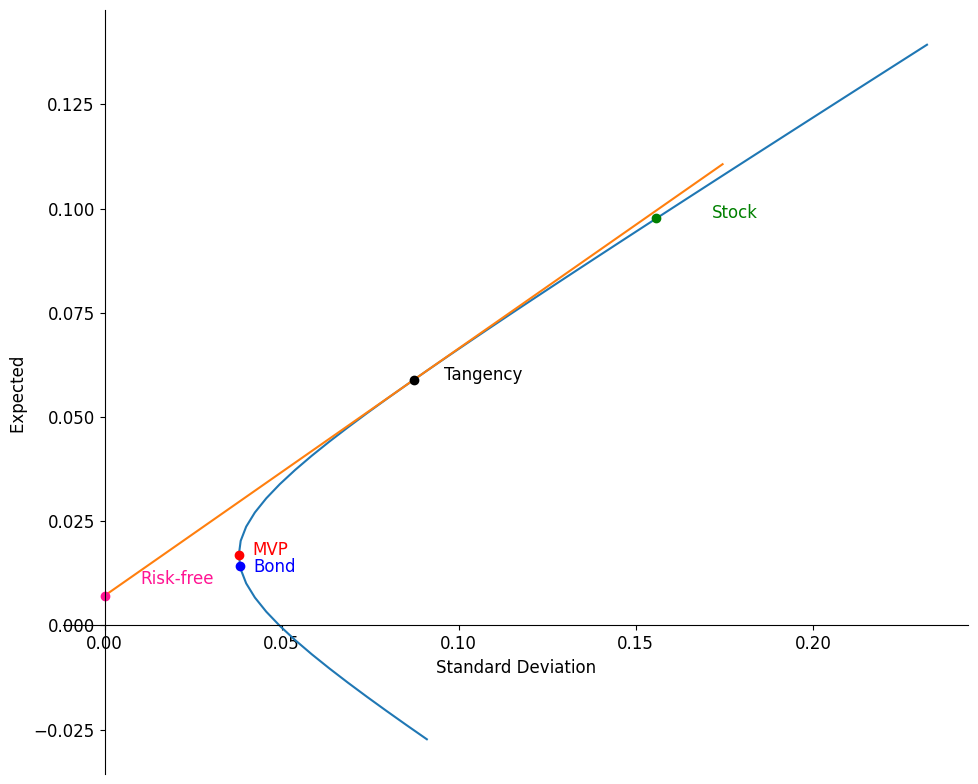

In [ ]:
# stock v
corr              = np.corrcoef(rets_mva[:,[stock,bond]],rowvar=False)[1,0]
create_tangency_portfolio(mu_1, mu_2, mu_rf, s_1, s_2, corr, "Stock", "Bond")

MVP: Portfolio Weights
 Stock   Bitcoin
0.0446 0.9554
Expected return: 0.0181
Volatility: 0.0376
Tangency: Portfolio Weights
 Stock   Bitcoin
0.4732 0.5268
Expected return: 0.0538
Volatility: 0.0775


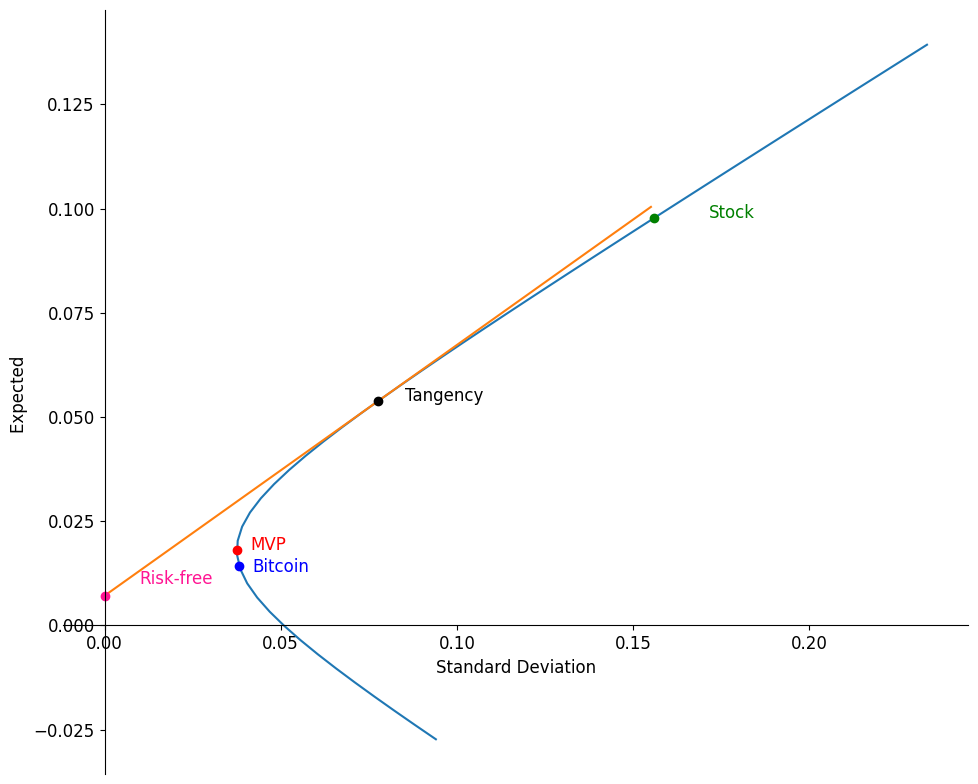

In [ ]:
# stock v
corr              = np.corrcoef(rets_mva[:,[stock,btc]],rowvar=False)[1,0]
create_tangency_portfolio(mu_1, mu_2, mu_rf, s_1, s_2, corr, "Stock", "Bitcoin")

MVP: Portfolio Weights
 Bond   Bitcoin
0.0574 0.9426
Expected return: 0.0191
Volatility: 0.0371
Tangency: Portfolio Weights
 Bond   Bitcoin
0.4276 0.5724
Expected return: 0.0500
Volatility: 0.0701


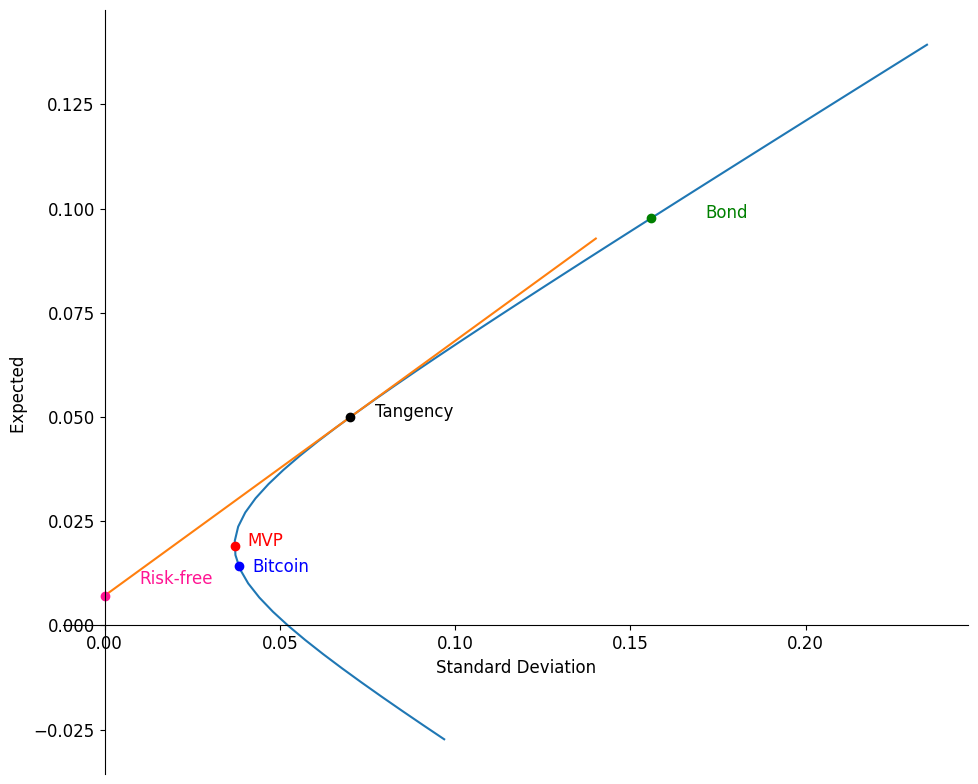

In [ ]:
# stock v
corr              = np.corrcoef(rets_mva[:,[bond,btc]],rowvar=False)[1,0]
create_tangency_portfolio(mu_1, mu_2, mu_rf, s_1, s_2, corr, "Bond", "Bitcoin")

**Question 4:** Does investing in Bitcoin ETFs offer a viable option to gain cryptocurrency exposure? What
are the differences between direct investment in bitcoin and investment in the ETFs? Perform
a data science workflow using the data (21-crypto-investing-etf.csv) provided with the lab
to answer these questions.


Investing in Bitcoin ETF is a viable option to gain exposure to cryptocurrency. They track the path of the cryptocurrency very closely, showing similar variance and returns. Aside from the fact that they only have roughly an 80% correlation to crypto, they do not seem to incorporate a positive hedge against its volatility in the long term. The gap in one-to-one correlation definitely creates some opportunities to generate alpha in the short term, but ultimately it would be just as effective, if not more so, to invest in bitcoin itself. This is of course assuming that Bill’s clients are comfortable holding onto crypto currency. If that is not the case, then it might be more convenient to focus on ETFs in the long run.

5. What risks of cryptocurrency are not captured by your formal analysis?

Network Security Vulnerabilities: Cryptocurrencies heavily rely on decentralized blockchain technology, which is not immune to security vulnerabilities. Potential risks include 51% attacks, where a single entity gains control over the majority of the network's mining power, leading to potential manipulation of transactions. Additionally, smart contract vulnerabilities and hacking incidents on cryptocurrency exchanges pose risks to the overall security of the ecosystem, which may not be fully accounted for in formal analyses.

Technological Innovation and Obsolescence: The fast-paced nature of technological advancements poses a risk to the cryptocurrency market. While a particular blockchain or cryptocurrency may be groundbreaking at the time of analysis, rapid technological innovation could lead to the emergence of more efficient or secure alternatives, rendering existing cryptocurrencies obsolete. Formal analyses may not capture the dynamic nature of technological evolution and its potential impact on the value and viability of specific cryptocurrencies.

Market Perception and Sentiment: Cryptocurrency markets are highly influenced by market sentiment and perception, which can be driven by social media, news, and public opinion. Unexpected events, such as regulatory developments or security breaches in other unrelated sectors, can significantly impact the sentiment surrounding cryptocurrencies. Formal analyses may not fully account for the unpredictable nature of public perception and its influence on market dynamics.

Liquidity Risks: Cryptocurrency markets can experience periods of low liquidity, especially for less popular or newer tokens. In times of heightened market volatility or economic uncertainty, liquidity can dry up, leading to wider bid-ask spreads and increased price slippage. The potential impact of liquidity risks on portfolio performance may not be adequately addressed in formal analyses, as they often assume continuous and efficient market conditions.


6. Based on your analysis, what should Bill recommend to his clientele? Be sure to support any
recommendations with evidence from your analysis.


Looking at the overall data on crypto currency over the last 7 years, it appears to be a very volatile investment with the potential for remarkable upside. Unfortunately, in recent years, it has shown itself capable of an astronomical magnitude of losses. If his clients have higher expectations of return, they should understand that it comes with a remarkable level of risk. Taking a look at the state of bitcoin at the moment, it appears that there was a significant bump in the perceived value of the crypto currency in 2020, but since mid 2021 it has been reeling from this false perception. If Bill believes that this was a circumstantial rollercoaster and the currency will ultimately remain in use for the long term, then he should recommend that his clientele invest. If Bill believes that the landscape of crypto is shifting away from bitcoin or even the use of crypto currency in general, he should seek other investments for his clients.